In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

In [2]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
shap.initjs()

In [4]:
data = pd.read_parquet('/main/data/MVideo_2/dataset_main_7_m_1.parquet')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719968 entries, 0 to 1719967
Data columns (total 99 columns):
STORE_ID                                               category
PRODUCT_ID                                             category
DATE                                                   datetime64[ns]
REGULAR_SALES_PRICE_INCL_TAX                           int32
MAINCATEGORY_ID                                        category
SUBCATEGORY_ID                                         category
REGION                                                 category
INTERNET                                               category
WEEK(DATE)                                             category
MONTH(DATE)                                            category
category.STD(trans.UNITS_SOLD_NP)_MAX_2                float32
category.SUM(trans.REVENUE_INCL_TAX_P)_MEAN_8          float32
category.SUM(trans.REVENUE_INCL_TAX_P)_MAX_8           float32
category.STD(trans.REVENUE_INCL_TAX)_MIN_8             

In [6]:
data_train = data[data.DATE < '2018-05-20']

In [7]:
data_train.shape[0]

1441648

In [8]:
data_train2 = data[data.DATE <= '2018-06-10']

In [9]:
data_train2.shape[0]

1580808

In [10]:
data_val = data[(data.DATE >= '2018-05-20') & (data.DATE <= '2018-06-10')]

In [11]:
data_val.shape[0]

139160

In [12]:
data_test = data[data.DATE == '2018-07-08']

In [13]:
data_test.shape[0]

34790

In [14]:
feat = [s for s in data.columns if s not in ['DATE', 'UNITS_SOLD_P1']]

In [15]:
dts = lgb.Dataset(data_train[feat], label = data_train.UNITS_SOLD_P1)

In [16]:
dts = dts.construct()

In [17]:
dtsv = dts.create_valid(data_val[feat], label = data_val.UNITS_SOLD_P1)

In [18]:
space = {
        'num_leaves': hp.quniform('num_leaves', 3, 9, 1),
        'min_data_in_leaf':hp.quniform('min_data_in_leaf', 10, 1000, 10),
        'min_sum_hessian_in_leaf': hp.quniform('min_sum_hessian_in_leaf', -5, 2, 1),
        'feature_fraction': hp.quniform('feature_fraction', 0.5, 1, 0.1),
        'bagging_fraction': hp.quniform('bagging_fraction', 0.5, 1, 0.1),
        'bagging_freq': hp.quniform('bagging_freq', 0, 10, 1),
        'lambda_l2': hp.loguniform('lambda_l2', -9, 3),
       }

In [19]:
def get_params(space):
    params = dict()
    params['application'] = 'regression_l2'
    params['learning_rate'] = 0.03
    params['num_leaves'] = 2 ** int(space['num_leaves']) - 1
    params['min_data_in_leaf'] = int(space['min_data_in_leaf'])
    params['min_sum_hessian_in_leaf'] = 10 ** int(space['min_sum_hessian_in_leaf'])
    params['feature_fraction'] = np.round(space['feature_fraction'], 1)
    params['bagging_fraction'] = np.round(space['bagging_fraction'], 1)
    params['bagging_freq'] = int(space['bagging_freq'])
    params['lambda_l2'] = np.round(space['lambda_l2'], 4)
    params['metric'] = 'l2_root'
    return params

In [20]:
def objective_reg(space):
    params = get_params(space)
    bst = lgb.train(params, dts, valid_sets = [dtsv], valid_names = ['Validation'], num_boost_round = 10000,
                    early_stopping_rounds = 20)
    pred = bst.predict(data_val[feat])
    test_loss = mean_squared_error(data_val.UNITS_SOLD_P1, pred) ** 0.5
    return{'loss': test_loss, 'status': STATUS_OK, 'attachments': params}

In [21]:
N_HYPEROPT_PROBES = 30
HYPEROPT_ALGO = tpe.suggest #hyperopt.rand.suggest

trials = Trials()
best = fmin(fn=objective_reg,
            space=space,
            algo=HYPEROPT_ALGO,
            max_evals=N_HYPEROPT_PROBES,
            trials=trials,
            verbose=1)

[1]	Validation's rmse: 1.96116
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.93393
[3]	Validation's rmse: 1.91208
[4]	Validation's rmse: 1.88893
[5]	Validation's rmse: 1.86817
[6]	Validation's rmse: 1.84788
[7]	Validation's rmse: 1.82785
[8]	Validation's rmse: 1.80911
[9]	Validation's rmse: 1.79239
[10]	Validation's rmse: 1.77478
[11]	Validation's rmse: 1.76428
[12]	Validation's rmse: 1.74896
[13]	Validation's rmse: 1.73565
[14]	Validation's rmse: 1.71937
[15]	Validation's rmse: 1.70619
[16]	Validation's rmse: 1.69566
[17]	Validation's rmse: 1.68179
[18]	Validation's rmse: 1.66776
[19]	Validation's rmse: 1.65454
[20]	Validation's rmse: 1.64533
[21]	Validation's rmse: 1.63452
[22]	Validation's rmse: 1.6231
[23]	Validation's rmse: 1.61396
[24]	Validation's rmse: 1.60563
[25]	Validation's rmse: 1.59555
[26]	Validation's rmse: 1.58648
[27]	Validation's rmse: 1.57731
[28]	Validation's rmse: 1.56906
[29]	Validation's rmse: 1.56218
[30]	Validation's rm

[256]	Validation's rmse: 1.36281
[257]	Validation's rmse: 1.36272
[258]	Validation's rmse: 1.36268
[259]	Validation's rmse: 1.36266
[260]	Validation's rmse: 1.36257
[261]	Validation's rmse: 1.3625
[262]	Validation's rmse: 1.36246
[263]	Validation's rmse: 1.36258
[264]	Validation's rmse: 1.36257
[265]	Validation's rmse: 1.36243
[266]	Validation's rmse: 1.36248
[267]	Validation's rmse: 1.36241
[268]	Validation's rmse: 1.36251
[269]	Validation's rmse: 1.36248
[270]	Validation's rmse: 1.36225
[271]	Validation's rmse: 1.36216
[272]	Validation's rmse: 1.36218
[273]	Validation's rmse: 1.3622
[274]	Validation's rmse: 1.36218
[275]	Validation's rmse: 1.3622
[276]	Validation's rmse: 1.36274
[277]	Validation's rmse: 1.36292
[278]	Validation's rmse: 1.36294
[279]	Validation's rmse: 1.36295
[280]	Validation's rmse: 1.36302
[281]	Validation's rmse: 1.36303
[282]	Validation's rmse: 1.36297
[283]	Validation's rmse: 1.36252
[284]	Validation's rmse: 1.36257
[285]	Validation's rmse: 1.36252
[286]	Validat

[119]	Validation's rmse: 1.37798
[120]	Validation's rmse: 1.37768
[121]	Validation's rmse: 1.37718
[122]	Validation's rmse: 1.37699
[123]	Validation's rmse: 1.37639
[124]	Validation's rmse: 1.37629
[125]	Validation's rmse: 1.37586
[126]	Validation's rmse: 1.37546
[127]	Validation's rmse: 1.37495
[128]	Validation's rmse: 1.37498
[129]	Validation's rmse: 1.37476
[130]	Validation's rmse: 1.37441
[131]	Validation's rmse: 1.37431
[132]	Validation's rmse: 1.37378
[133]	Validation's rmse: 1.37336
[134]	Validation's rmse: 1.37312
[135]	Validation's rmse: 1.37287
[136]	Validation's rmse: 1.37284
[137]	Validation's rmse: 1.37264
[138]	Validation's rmse: 1.37237
[139]	Validation's rmse: 1.37206
[140]	Validation's rmse: 1.3717
[141]	Validation's rmse: 1.37127
[142]	Validation's rmse: 1.37103
[143]	Validation's rmse: 1.37108
[144]	Validation's rmse: 1.37072
[145]	Validation's rmse: 1.37061
[146]	Validation's rmse: 1.37026
[147]	Validation's rmse: 1.36987
[148]	Validation's rmse: 1.36978
[149]	Valid

[368]	Validation's rmse: 1.3598
[369]	Validation's rmse: 1.35983
[370]	Validation's rmse: 1.35987
[371]	Validation's rmse: 1.35991
[372]	Validation's rmse: 1.35977
[373]	Validation's rmse: 1.35979
[374]	Validation's rmse: 1.35992
[375]	Validation's rmse: 1.35991
[376]	Validation's rmse: 1.35992
[377]	Validation's rmse: 1.35983
[378]	Validation's rmse: 1.35979
[379]	Validation's rmse: 1.35973
[380]	Validation's rmse: 1.35952
[381]	Validation's rmse: 1.3595
[382]	Validation's rmse: 1.35949
[383]	Validation's rmse: 1.3596
[384]	Validation's rmse: 1.35967
[385]	Validation's rmse: 1.35955
[386]	Validation's rmse: 1.35956
[387]	Validation's rmse: 1.35954
[388]	Validation's rmse: 1.35945
[389]	Validation's rmse: 1.35958
[390]	Validation's rmse: 1.35955
[391]	Validation's rmse: 1.35955
[392]	Validation's rmse: 1.35945
[393]	Validation's rmse: 1.35945
[394]	Validation's rmse: 1.35952
[395]	Validation's rmse: 1.35956
[396]	Validation's rmse: 1.35956
[397]	Validation's rmse: 1.35957
[398]	Validat

[153]	Validation's rmse: 1.39028
[154]	Validation's rmse: 1.39054
[155]	Validation's rmse: 1.39061
[156]	Validation's rmse: 1.39059
[157]	Validation's rmse: 1.39024
[158]	Validation's rmse: 1.3902
[159]	Validation's rmse: 1.39016
[160]	Validation's rmse: 1.39015
[161]	Validation's rmse: 1.39003
[162]	Validation's rmse: 1.39002
[163]	Validation's rmse: 1.38956
[164]	Validation's rmse: 1.38891
[165]	Validation's rmse: 1.38872
[166]	Validation's rmse: 1.38856
[167]	Validation's rmse: 1.38804
[168]	Validation's rmse: 1.38776
[169]	Validation's rmse: 1.38759
[170]	Validation's rmse: 1.38753
[171]	Validation's rmse: 1.38735
[172]	Validation's rmse: 1.38708
[173]	Validation's rmse: 1.38656
[174]	Validation's rmse: 1.38643
[175]	Validation's rmse: 1.3861
[176]	Validation's rmse: 1.38574
[177]	Validation's rmse: 1.38561
[178]	Validation's rmse: 1.38558
[179]	Validation's rmse: 1.38535
[180]	Validation's rmse: 1.38512
[181]	Validation's rmse: 1.38509
[182]	Validation's rmse: 1.38499
[183]	Valida

[56]	Validation's rmse: 1.43478
[57]	Validation's rmse: 1.43196
[58]	Validation's rmse: 1.43004
[59]	Validation's rmse: 1.4285
[60]	Validation's rmse: 1.42593
[61]	Validation's rmse: 1.42421
[62]	Validation's rmse: 1.42259
[63]	Validation's rmse: 1.42125
[64]	Validation's rmse: 1.41916
[65]	Validation's rmse: 1.41744
[66]	Validation's rmse: 1.41666
[67]	Validation's rmse: 1.41461
[68]	Validation's rmse: 1.41423
[69]	Validation's rmse: 1.41267
[70]	Validation's rmse: 1.41166
[71]	Validation's rmse: 1.41056
[72]	Validation's rmse: 1.40848
[73]	Validation's rmse: 1.40755
[74]	Validation's rmse: 1.40653
[75]	Validation's rmse: 1.40576
[76]	Validation's rmse: 1.40424
[77]	Validation's rmse: 1.4031
[78]	Validation's rmse: 1.4022
[79]	Validation's rmse: 1.401
[80]	Validation's rmse: 1.39983
[81]	Validation's rmse: 1.39933
[82]	Validation's rmse: 1.39829
[83]	Validation's rmse: 1.39787
[84]	Validation's rmse: 1.39678
[85]	Validation's rmse: 1.39623
[86]	Validation's rmse: 1.39503
[87]	Validati

[16]	Validation's rmse: 1.68281
[17]	Validation's rmse: 1.66881
[18]	Validation's rmse: 1.6572
[19]	Validation's rmse: 1.64431
[20]	Validation's rmse: 1.63531
[21]	Validation's rmse: 1.62346
[22]	Validation's rmse: 1.61218
[23]	Validation's rmse: 1.60235
[24]	Validation's rmse: 1.59416
[25]	Validation's rmse: 1.58415
[26]	Validation's rmse: 1.57468
[27]	Validation's rmse: 1.5653
[28]	Validation's rmse: 1.55661
[29]	Validation's rmse: 1.54919
[30]	Validation's rmse: 1.54201
[31]	Validation's rmse: 1.53421
[32]	Validation's rmse: 1.52742
[33]	Validation's rmse: 1.52131
[34]	Validation's rmse: 1.51454
[35]	Validation's rmse: 1.50887
[36]	Validation's rmse: 1.50285
[37]	Validation's rmse: 1.49746
[38]	Validation's rmse: 1.49136
[39]	Validation's rmse: 1.48695
[40]	Validation's rmse: 1.4821
[41]	Validation's rmse: 1.47657
[42]	Validation's rmse: 1.47255
[43]	Validation's rmse: 1.46867
[44]	Validation's rmse: 1.46568
[45]	Validation's rmse: 1.46187
[46]	Validation's rmse: 1.45877
[47]	Valida

[269]	Validation's rmse: 1.36075
[270]	Validation's rmse: 1.36081
[271]	Validation's rmse: 1.36082
[272]	Validation's rmse: 1.36059
[273]	Validation's rmse: 1.36065
[274]	Validation's rmse: 1.36064
[275]	Validation's rmse: 1.36052
[276]	Validation's rmse: 1.36043
[277]	Validation's rmse: 1.36036
[278]	Validation's rmse: 1.36004
[279]	Validation's rmse: 1.35998
[280]	Validation's rmse: 1.35976
[281]	Validation's rmse: 1.35958
[282]	Validation's rmse: 1.35957
[283]	Validation's rmse: 1.35973
[284]	Validation's rmse: 1.35977
[285]	Validation's rmse: 1.35981
[286]	Validation's rmse: 1.35979
[287]	Validation's rmse: 1.35979
[288]	Validation's rmse: 1.35977
[289]	Validation's rmse: 1.35979
[290]	Validation's rmse: 1.35976
[291]	Validation's rmse: 1.35967
[292]	Validation's rmse: 1.35965
[293]	Validation's rmse: 1.35968
[294]	Validation's rmse: 1.35956
[295]	Validation's rmse: 1.35966
[296]	Validation's rmse: 1.35976
[297]	Validation's rmse: 1.35969
[298]	Validation's rmse: 1.35968
[299]	Vali

[215]	Validation's rmse: 1.39393
[216]	Validation's rmse: 1.39364
[217]	Validation's rmse: 1.39356
[218]	Validation's rmse: 1.39328
[219]	Validation's rmse: 1.39313
[220]	Validation's rmse: 1.39308
[221]	Validation's rmse: 1.39331
[222]	Validation's rmse: 1.39324
[223]	Validation's rmse: 1.39313
[224]	Validation's rmse: 1.39314
[225]	Validation's rmse: 1.39306
[226]	Validation's rmse: 1.39266
[227]	Validation's rmse: 1.39266
[228]	Validation's rmse: 1.39246
[229]	Validation's rmse: 1.39202
[230]	Validation's rmse: 1.39205
[231]	Validation's rmse: 1.39217
[232]	Validation's rmse: 1.39199
[233]	Validation's rmse: 1.3919
[234]	Validation's rmse: 1.39188
[235]	Validation's rmse: 1.39171
[236]	Validation's rmse: 1.39156
[237]	Validation's rmse: 1.39148
[238]	Validation's rmse: 1.39142
[239]	Validation's rmse: 1.39153
[240]	Validation's rmse: 1.39139
[241]	Validation's rmse: 1.3911
[242]	Validation's rmse: 1.39106
[243]	Validation's rmse: 1.39097
[244]	Validation's rmse: 1.39085
[245]	Valida

[474]	Validation's rmse: 1.37791
[475]	Validation's rmse: 1.37783
[476]	Validation's rmse: 1.37774
[477]	Validation's rmse: 1.37784
[478]	Validation's rmse: 1.37785
[479]	Validation's rmse: 1.37783
[480]	Validation's rmse: 1.37787
[481]	Validation's rmse: 1.37785
[482]	Validation's rmse: 1.37785
[483]	Validation's rmse: 1.37783
[484]	Validation's rmse: 1.37789
[485]	Validation's rmse: 1.37779
[486]	Validation's rmse: 1.37775
[487]	Validation's rmse: 1.37775
[488]	Validation's rmse: 1.37761
[489]	Validation's rmse: 1.37761
[490]	Validation's rmse: 1.37762
[491]	Validation's rmse: 1.37717
[492]	Validation's rmse: 1.37716
[493]	Validation's rmse: 1.37707
[494]	Validation's rmse: 1.37706
[495]	Validation's rmse: 1.37684
[496]	Validation's rmse: 1.37684
[497]	Validation's rmse: 1.3768
[498]	Validation's rmse: 1.37673
[499]	Validation's rmse: 1.37667
[500]	Validation's rmse: 1.37666
[501]	Validation's rmse: 1.37668
[502]	Validation's rmse: 1.37663
[503]	Validation's rmse: 1.37664
[504]	Valid

[737]	Validation's rmse: 1.37007
[738]	Validation's rmse: 1.37006
[739]	Validation's rmse: 1.36997
[740]	Validation's rmse: 1.36995
[741]	Validation's rmse: 1.3699
[742]	Validation's rmse: 1.36989
[743]	Validation's rmse: 1.36987
[744]	Validation's rmse: 1.36992
[745]	Validation's rmse: 1.3699
[746]	Validation's rmse: 1.3699
[747]	Validation's rmse: 1.36992
[748]	Validation's rmse: 1.36973
[749]	Validation's rmse: 1.36979
[750]	Validation's rmse: 1.36974
[751]	Validation's rmse: 1.36972
[752]	Validation's rmse: 1.36984
[753]	Validation's rmse: 1.36983
[754]	Validation's rmse: 1.36969
[755]	Validation's rmse: 1.36951
[756]	Validation's rmse: 1.36955
[757]	Validation's rmse: 1.36952
[758]	Validation's rmse: 1.36948
[759]	Validation's rmse: 1.36951
[760]	Validation's rmse: 1.36952
[761]	Validation's rmse: 1.36955
[762]	Validation's rmse: 1.36955
[763]	Validation's rmse: 1.36954
[764]	Validation's rmse: 1.3695
[765]	Validation's rmse: 1.36943
[766]	Validation's rmse: 1.36938
[767]	Validati

[997]	Validation's rmse: 1.36504
[998]	Validation's rmse: 1.36501
[999]	Validation's rmse: 1.36501
[1000]	Validation's rmse: 1.36508
[1001]	Validation's rmse: 1.36513
[1002]	Validation's rmse: 1.36522
[1003]	Validation's rmse: 1.36522
[1004]	Validation's rmse: 1.36534
[1005]	Validation's rmse: 1.36538
[1006]	Validation's rmse: 1.36544
[1007]	Validation's rmse: 1.36546
[1008]	Validation's rmse: 1.36542
[1009]	Validation's rmse: 1.36546
[1010]	Validation's rmse: 1.36541
[1011]	Validation's rmse: 1.36543
[1012]	Validation's rmse: 1.36543
[1013]	Validation's rmse: 1.36544
Early stopping, best iteration is:
[993]	Validation's rmse: 1.36494
[1]	Validation's rmse: 1.962
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.93393
[3]	Validation's rmse: 1.90729
[4]	Validation's rmse: 1.88275
[5]	Validation's rmse: 1.86171
[6]	Validation's rmse: 1.84553
[7]	Validation's rmse: 1.8231
[8]	Validation's rmse: 1.80282
[9]	Validation's rmse: 1.78299
[10]	Validation's r

[232]	Validation's rmse: 1.35757
[233]	Validation's rmse: 1.35751
[234]	Validation's rmse: 1.35756
[235]	Validation's rmse: 1.35748
[236]	Validation's rmse: 1.3575
[237]	Validation's rmse: 1.35755
[238]	Validation's rmse: 1.35734
[239]	Validation's rmse: 1.35735
[240]	Validation's rmse: 1.35727
[241]	Validation's rmse: 1.3572
[242]	Validation's rmse: 1.35704
[243]	Validation's rmse: 1.35704
[244]	Validation's rmse: 1.35703
[245]	Validation's rmse: 1.3571
[246]	Validation's rmse: 1.35734
[247]	Validation's rmse: 1.35724
[248]	Validation's rmse: 1.35723
[249]	Validation's rmse: 1.35723
[250]	Validation's rmse: 1.35713
[251]	Validation's rmse: 1.3571
[252]	Validation's rmse: 1.35716
[253]	Validation's rmse: 1.35715
[254]	Validation's rmse: 1.35711
[255]	Validation's rmse: 1.35721
[256]	Validation's rmse: 1.35705
[257]	Validation's rmse: 1.35698
[258]	Validation's rmse: 1.35695
[259]	Validation's rmse: 1.35678
[260]	Validation's rmse: 1.35678
[261]	Validation's rmse: 1.35682
[262]	Validati

[189]	Validation's rmse: 1.35992
[190]	Validation's rmse: 1.35987
[191]	Validation's rmse: 1.35979
[192]	Validation's rmse: 1.35975
[193]	Validation's rmse: 1.35973
[194]	Validation's rmse: 1.35959
[195]	Validation's rmse: 1.35947
[196]	Validation's rmse: 1.35935
[197]	Validation's rmse: 1.35944
[198]	Validation's rmse: 1.35951
[199]	Validation's rmse: 1.35946
[200]	Validation's rmse: 1.35954
[201]	Validation's rmse: 1.35969
[202]	Validation's rmse: 1.35965
[203]	Validation's rmse: 1.35953
[204]	Validation's rmse: 1.35942
[205]	Validation's rmse: 1.35925
[206]	Validation's rmse: 1.35898
[207]	Validation's rmse: 1.3588
[208]	Validation's rmse: 1.35881
[209]	Validation's rmse: 1.35891
[210]	Validation's rmse: 1.35882
[211]	Validation's rmse: 1.35872
[212]	Validation's rmse: 1.35869
[213]	Validation's rmse: 1.35856
[214]	Validation's rmse: 1.35866
[215]	Validation's rmse: 1.35869
[216]	Validation's rmse: 1.35858
[217]	Validation's rmse: 1.35833
[218]	Validation's rmse: 1.35847
[219]	Valid

[146]	Validation's rmse: 1.36993
[147]	Validation's rmse: 1.36941
[148]	Validation's rmse: 1.36931
[149]	Validation's rmse: 1.36907
[150]	Validation's rmse: 1.36888
[151]	Validation's rmse: 1.36918
[152]	Validation's rmse: 1.36893
[153]	Validation's rmse: 1.36881
[154]	Validation's rmse: 1.36841
[155]	Validation's rmse: 1.36803
[156]	Validation's rmse: 1.36765
[157]	Validation's rmse: 1.36736
[158]	Validation's rmse: 1.36741
[159]	Validation's rmse: 1.36723
[160]	Validation's rmse: 1.36719
[161]	Validation's rmse: 1.36708
[162]	Validation's rmse: 1.36724
[163]	Validation's rmse: 1.36713
[164]	Validation's rmse: 1.36707
[165]	Validation's rmse: 1.36698
[166]	Validation's rmse: 1.36683
[167]	Validation's rmse: 1.36662
[168]	Validation's rmse: 1.36668
[169]	Validation's rmse: 1.36652
[170]	Validation's rmse: 1.36625
[171]	Validation's rmse: 1.3661
[172]	Validation's rmse: 1.36602
[173]	Validation's rmse: 1.36589
[174]	Validation's rmse: 1.36599
[175]	Validation's rmse: 1.36593
[176]	Valid

[149]	Validation's rmse: 1.36769
[150]	Validation's rmse: 1.36756
[151]	Validation's rmse: 1.36747
[152]	Validation's rmse: 1.36703
[153]	Validation's rmse: 1.36689
[154]	Validation's rmse: 1.36682
[155]	Validation's rmse: 1.36671
[156]	Validation's rmse: 1.36655
[157]	Validation's rmse: 1.36656
[158]	Validation's rmse: 1.36652
[159]	Validation's rmse: 1.36633
[160]	Validation's rmse: 1.36632
[161]	Validation's rmse: 1.36632
[162]	Validation's rmse: 1.36623
[163]	Validation's rmse: 1.36627
[164]	Validation's rmse: 1.36607
[165]	Validation's rmse: 1.36613
[166]	Validation's rmse: 1.36582
[167]	Validation's rmse: 1.36586
[168]	Validation's rmse: 1.36565
[169]	Validation's rmse: 1.36571
[170]	Validation's rmse: 1.3656
[171]	Validation's rmse: 1.36552
[172]	Validation's rmse: 1.36556
[173]	Validation's rmse: 1.36533
[174]	Validation's rmse: 1.36509
[175]	Validation's rmse: 1.3651
[176]	Validation's rmse: 1.36501
[177]	Validation's rmse: 1.36496
[178]	Validation's rmse: 1.36481
[179]	Valida

[171]	Validation's rmse: 1.38737
[172]	Validation's rmse: 1.38711
[173]	Validation's rmse: 1.38696
[174]	Validation's rmse: 1.38687
[175]	Validation's rmse: 1.38662
[176]	Validation's rmse: 1.38651
[177]	Validation's rmse: 1.38636
[178]	Validation's rmse: 1.38638
[179]	Validation's rmse: 1.38623
[180]	Validation's rmse: 1.3859
[181]	Validation's rmse: 1.38578
[182]	Validation's rmse: 1.3854
[183]	Validation's rmse: 1.38527
[184]	Validation's rmse: 1.38503
[185]	Validation's rmse: 1.38479
[186]	Validation's rmse: 1.38454
[187]	Validation's rmse: 1.38456
[188]	Validation's rmse: 1.38434
[189]	Validation's rmse: 1.38394
[190]	Validation's rmse: 1.38389
[191]	Validation's rmse: 1.38377
[192]	Validation's rmse: 1.38363
[193]	Validation's rmse: 1.3837
[194]	Validation's rmse: 1.38373
[195]	Validation's rmse: 1.38359
[196]	Validation's rmse: 1.38413
[197]	Validation's rmse: 1.38389
[198]	Validation's rmse: 1.3836
[199]	Validation's rmse: 1.38338
[200]	Validation's rmse: 1.38325
[201]	Validati

[424]	Validation's rmse: 1.36856
[425]	Validation's rmse: 1.36857
[426]	Validation's rmse: 1.36856
[427]	Validation's rmse: 1.36853
[428]	Validation's rmse: 1.36848
[429]	Validation's rmse: 1.3684
[430]	Validation's rmse: 1.36838
[431]	Validation's rmse: 1.36835
[432]	Validation's rmse: 1.36829
[433]	Validation's rmse: 1.3682
[434]	Validation's rmse: 1.36823
[435]	Validation's rmse: 1.3681
[436]	Validation's rmse: 1.36799
[437]	Validation's rmse: 1.36794
[438]	Validation's rmse: 1.36798
[439]	Validation's rmse: 1.36785
[440]	Validation's rmse: 1.36785
[441]	Validation's rmse: 1.36753
[442]	Validation's rmse: 1.36741
[443]	Validation's rmse: 1.36727
[444]	Validation's rmse: 1.36703
[445]	Validation's rmse: 1.36706
[446]	Validation's rmse: 1.36703
[447]	Validation's rmse: 1.36682
[448]	Validation's rmse: 1.36685
[449]	Validation's rmse: 1.36685
[450]	Validation's rmse: 1.36672
[451]	Validation's rmse: 1.36675
[452]	Validation's rmse: 1.36677
[453]	Validation's rmse: 1.3667
[454]	Validati

[96]	Validation's rmse: 1.41792
[97]	Validation's rmse: 1.41713
[98]	Validation's rmse: 1.4165
[99]	Validation's rmse: 1.41569
[100]	Validation's rmse: 1.41501
[101]	Validation's rmse: 1.41451
[102]	Validation's rmse: 1.4139
[103]	Validation's rmse: 1.41351
[104]	Validation's rmse: 1.41227
[105]	Validation's rmse: 1.41176
[106]	Validation's rmse: 1.41106
[107]	Validation's rmse: 1.41007
[108]	Validation's rmse: 1.40955
[109]	Validation's rmse: 1.40879
[110]	Validation's rmse: 1.40839
[111]	Validation's rmse: 1.40747
[112]	Validation's rmse: 1.40708
[113]	Validation's rmse: 1.40676
[114]	Validation's rmse: 1.40583
[115]	Validation's rmse: 1.40513
[116]	Validation's rmse: 1.40449
[117]	Validation's rmse: 1.40396
[118]	Validation's rmse: 1.40353
[119]	Validation's rmse: 1.40321
[120]	Validation's rmse: 1.4026
[121]	Validation's rmse: 1.40228
[122]	Validation's rmse: 1.40177
[123]	Validation's rmse: 1.40166
[124]	Validation's rmse: 1.40094
[125]	Validation's rmse: 1.40046
[126]	Validation'

[348]	Validation's rmse: 1.36858
[349]	Validation's rmse: 1.36845
[350]	Validation's rmse: 1.36841
[351]	Validation's rmse: 1.36834
[352]	Validation's rmse: 1.36839
[353]	Validation's rmse: 1.36837
[354]	Validation's rmse: 1.36831
[355]	Validation's rmse: 1.36836
[356]	Validation's rmse: 1.36819
[357]	Validation's rmse: 1.36816
[358]	Validation's rmse: 1.3682
[359]	Validation's rmse: 1.36812
[360]	Validation's rmse: 1.36801
[361]	Validation's rmse: 1.368
[362]	Validation's rmse: 1.36793
[363]	Validation's rmse: 1.36773
[364]	Validation's rmse: 1.36771
[365]	Validation's rmse: 1.3676
[366]	Validation's rmse: 1.36757
[367]	Validation's rmse: 1.36759
[368]	Validation's rmse: 1.3675
[369]	Validation's rmse: 1.36743
[370]	Validation's rmse: 1.36741
[371]	Validation's rmse: 1.36739
[372]	Validation's rmse: 1.36728
[373]	Validation's rmse: 1.36718
[374]	Validation's rmse: 1.36735
[375]	Validation's rmse: 1.36732
[376]	Validation's rmse: 1.36741
[377]	Validation's rmse: 1.36737
[378]	Validatio

[599]	Validation's rmse: 1.36118
[600]	Validation's rmse: 1.36123
[601]	Validation's rmse: 1.36123
[602]	Validation's rmse: 1.36124
[603]	Validation's rmse: 1.36096
[604]	Validation's rmse: 1.36112
[605]	Validation's rmse: 1.36115
[606]	Validation's rmse: 1.36116
[607]	Validation's rmse: 1.36112
[608]	Validation's rmse: 1.36118
[609]	Validation's rmse: 1.36118
[610]	Validation's rmse: 1.36116
Early stopping, best iteration is:
[590]	Validation's rmse: 1.36094
[1]	Validation's rmse: 1.96021
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.93097
[3]	Validation's rmse: 1.90269
[4]	Validation's rmse: 1.87823
[5]	Validation's rmse: 1.85561
[6]	Validation's rmse: 1.83876
[7]	Validation's rmse: 1.81584
[8]	Validation's rmse: 1.79601
[9]	Validation's rmse: 1.77608
[10]	Validation's rmse: 1.75691
[11]	Validation's rmse: 1.74401
[12]	Validation's rmse: 1.72828
[13]	Validation's rmse: 1.71334
[14]	Validation's rmse: 1.69599
[15]	Validation's rmse: 1.67865
[16

[238]	Validation's rmse: 1.35316
[239]	Validation's rmse: 1.35309
[240]	Validation's rmse: 1.35308
[241]	Validation's rmse: 1.35311
[242]	Validation's rmse: 1.35285
[243]	Validation's rmse: 1.35287
[244]	Validation's rmse: 1.35274
[245]	Validation's rmse: 1.35264
[246]	Validation's rmse: 1.35272
[247]	Validation's rmse: 1.35262
[248]	Validation's rmse: 1.3526
[249]	Validation's rmse: 1.3525
[250]	Validation's rmse: 1.3524
[251]	Validation's rmse: 1.35242
[252]	Validation's rmse: 1.35234
[253]	Validation's rmse: 1.35234
[254]	Validation's rmse: 1.35234
[255]	Validation's rmse: 1.35235
[256]	Validation's rmse: 1.35238
[257]	Validation's rmse: 1.35228
[258]	Validation's rmse: 1.35221
[259]	Validation's rmse: 1.35214
[260]	Validation's rmse: 1.35214
[261]	Validation's rmse: 1.35208
[262]	Validation's rmse: 1.35198
[263]	Validation's rmse: 1.35197
[264]	Validation's rmse: 1.35195
[265]	Validation's rmse: 1.35198
[266]	Validation's rmse: 1.35186
[267]	Validation's rmse: 1.35175
[268]	Validat

[488]	Validation's rmse: 1.34508
[489]	Validation's rmse: 1.34508
[490]	Validation's rmse: 1.34508
[491]	Validation's rmse: 1.34501
[492]	Validation's rmse: 1.34489
[493]	Validation's rmse: 1.34484
[494]	Validation's rmse: 1.34481
[495]	Validation's rmse: 1.3448
[496]	Validation's rmse: 1.34471
[497]	Validation's rmse: 1.34475
[498]	Validation's rmse: 1.3447
[499]	Validation's rmse: 1.34466
[500]	Validation's rmse: 1.34465
[501]	Validation's rmse: 1.3446
[502]	Validation's rmse: 1.34461
[503]	Validation's rmse: 1.34456
[504]	Validation's rmse: 1.34457
[505]	Validation's rmse: 1.34461
[506]	Validation's rmse: 1.34463
[507]	Validation's rmse: 1.34457
[508]	Validation's rmse: 1.34466
[509]	Validation's rmse: 1.34463
[510]	Validation's rmse: 1.34458
[511]	Validation's rmse: 1.34452
[512]	Validation's rmse: 1.34446
[513]	Validation's rmse: 1.34437
[514]	Validation's rmse: 1.34435
[515]	Validation's rmse: 1.3444
[516]	Validation's rmse: 1.34439
[517]	Validation's rmse: 1.34433
[518]	Validati

[86]	Validation's rmse: 1.40769
[87]	Validation's rmse: 1.40671
[88]	Validation's rmse: 1.40646
[89]	Validation's rmse: 1.40574
[90]	Validation's rmse: 1.40499
[91]	Validation's rmse: 1.40353
[92]	Validation's rmse: 1.40284
[93]	Validation's rmse: 1.40194
[94]	Validation's rmse: 1.40073
[95]	Validation's rmse: 1.40039
[96]	Validation's rmse: 1.39942
[97]	Validation's rmse: 1.39822
[98]	Validation's rmse: 1.3979
[99]	Validation's rmse: 1.39759
[100]	Validation's rmse: 1.39701
[101]	Validation's rmse: 1.39562
[102]	Validation's rmse: 1.3954
[103]	Validation's rmse: 1.39494
[104]	Validation's rmse: 1.39426
[105]	Validation's rmse: 1.39355
[106]	Validation's rmse: 1.39274
[107]	Validation's rmse: 1.39228
[108]	Validation's rmse: 1.39195
[109]	Validation's rmse: 1.39081
[110]	Validation's rmse: 1.39085
[111]	Validation's rmse: 1.39035
[112]	Validation's rmse: 1.38982
[113]	Validation's rmse: 1.38949
[114]	Validation's rmse: 1.38854
[115]	Validation's rmse: 1.3881
[116]	Validation's rmse: 1.

[338]	Validation's rmse: 1.36114
[339]	Validation's rmse: 1.36117
[340]	Validation's rmse: 1.36125
[341]	Validation's rmse: 1.36129
[342]	Validation's rmse: 1.3612
[343]	Validation's rmse: 1.36127
[344]	Validation's rmse: 1.36124
[345]	Validation's rmse: 1.36126
[346]	Validation's rmse: 1.36127
[347]	Validation's rmse: 1.36123
[348]	Validation's rmse: 1.3612
[349]	Validation's rmse: 1.36095
[350]	Validation's rmse: 1.36097
[351]	Validation's rmse: 1.36084
[352]	Validation's rmse: 1.36083
[353]	Validation's rmse: 1.36078
[354]	Validation's rmse: 1.36065
[355]	Validation's rmse: 1.36066
[356]	Validation's rmse: 1.36072
[357]	Validation's rmse: 1.36051
[358]	Validation's rmse: 1.36043
[359]	Validation's rmse: 1.36047
[360]	Validation's rmse: 1.36046
[361]	Validation's rmse: 1.36047
[362]	Validation's rmse: 1.36041
[363]	Validation's rmse: 1.36031
[364]	Validation's rmse: 1.36018
[365]	Validation's rmse: 1.36014
[366]	Validation's rmse: 1.36008
[367]	Validation's rmse: 1.35998
[368]	Valida

[155]	Validation's rmse: 1.41131
[156]	Validation's rmse: 1.41116
[157]	Validation's rmse: 1.41108
[158]	Validation's rmse: 1.41089
[159]	Validation's rmse: 1.41034
[160]	Validation's rmse: 1.41046
[161]	Validation's rmse: 1.41024
[162]	Validation's rmse: 1.41008
[163]	Validation's rmse: 1.41003
[164]	Validation's rmse: 1.40966
[165]	Validation's rmse: 1.40908
[166]	Validation's rmse: 1.40869
[167]	Validation's rmse: 1.40861
[168]	Validation's rmse: 1.4086
[169]	Validation's rmse: 1.40851
[170]	Validation's rmse: 1.40827
[171]	Validation's rmse: 1.40758
[172]	Validation's rmse: 1.4074
[173]	Validation's rmse: 1.40747
[174]	Validation's rmse: 1.4074
[175]	Validation's rmse: 1.40728
[176]	Validation's rmse: 1.40732
[177]	Validation's rmse: 1.40715
[178]	Validation's rmse: 1.40692
[179]	Validation's rmse: 1.4064
[180]	Validation's rmse: 1.4061
[181]	Validation's rmse: 1.40596
[182]	Validation's rmse: 1.4058
[183]	Validation's rmse: 1.4058
[184]	Validation's rmse: 1.40593
[185]	Validation'

[405]	Validation's rmse: 1.38209
[406]	Validation's rmse: 1.38209
[407]	Validation's rmse: 1.38209
[408]	Validation's rmse: 1.38205
[409]	Validation's rmse: 1.38183
[410]	Validation's rmse: 1.38165
[411]	Validation's rmse: 1.38168
[412]	Validation's rmse: 1.38166
[413]	Validation's rmse: 1.3815
[414]	Validation's rmse: 1.38142
[415]	Validation's rmse: 1.38131
[416]	Validation's rmse: 1.38131
[417]	Validation's rmse: 1.38133
[418]	Validation's rmse: 1.38135
[419]	Validation's rmse: 1.38111
[420]	Validation's rmse: 1.3811
[421]	Validation's rmse: 1.38112
[422]	Validation's rmse: 1.38112
[423]	Validation's rmse: 1.38105
[424]	Validation's rmse: 1.38105
[425]	Validation's rmse: 1.38096
[426]	Validation's rmse: 1.38089
[427]	Validation's rmse: 1.38096
[428]	Validation's rmse: 1.38088
[429]	Validation's rmse: 1.38089
[430]	Validation's rmse: 1.38088
[431]	Validation's rmse: 1.38087
[432]	Validation's rmse: 1.38074
[433]	Validation's rmse: 1.38074
[434]	Validation's rmse: 1.38073
[435]	Valida

[658]	Validation's rmse: 1.37413
[659]	Validation's rmse: 1.3741
[660]	Validation's rmse: 1.37403
[661]	Validation's rmse: 1.37404
[662]	Validation's rmse: 1.37401
[663]	Validation's rmse: 1.37406
[664]	Validation's rmse: 1.37407
[665]	Validation's rmse: 1.37408
[666]	Validation's rmse: 1.37407
[667]	Validation's rmse: 1.37404
[668]	Validation's rmse: 1.37418
[669]	Validation's rmse: 1.37392
[670]	Validation's rmse: 1.37368
[671]	Validation's rmse: 1.37375
[672]	Validation's rmse: 1.37383
[673]	Validation's rmse: 1.37375
[674]	Validation's rmse: 1.37374
[675]	Validation's rmse: 1.37376
[676]	Validation's rmse: 1.37375
[677]	Validation's rmse: 1.37353
[678]	Validation's rmse: 1.37353
[679]	Validation's rmse: 1.37353
[680]	Validation's rmse: 1.3733
[681]	Validation's rmse: 1.37277
[682]	Validation's rmse: 1.37253
[683]	Validation's rmse: 1.37252
[684]	Validation's rmse: 1.37251
[685]	Validation's rmse: 1.37252
[686]	Validation's rmse: 1.37249
[687]	Validation's rmse: 1.37254
[688]	Valida

[911]	Validation's rmse: 1.36669
[912]	Validation's rmse: 1.3667
[913]	Validation's rmse: 1.36672
[914]	Validation's rmse: 1.36666
[915]	Validation's rmse: 1.36667
[916]	Validation's rmse: 1.36657
[917]	Validation's rmse: 1.36658
[918]	Validation's rmse: 1.36657
[919]	Validation's rmse: 1.36662
[920]	Validation's rmse: 1.36662
[921]	Validation's rmse: 1.36661
[922]	Validation's rmse: 1.3666
[923]	Validation's rmse: 1.36654
[924]	Validation's rmse: 1.36646
[925]	Validation's rmse: 1.3665
[926]	Validation's rmse: 1.36647
[927]	Validation's rmse: 1.36641
[928]	Validation's rmse: 1.36632
[929]	Validation's rmse: 1.36634
[930]	Validation's rmse: 1.36629
[931]	Validation's rmse: 1.36623
[932]	Validation's rmse: 1.36622
[933]	Validation's rmse: 1.36617
[934]	Validation's rmse: 1.36617
[935]	Validation's rmse: 1.36617
[936]	Validation's rmse: 1.36619
[937]	Validation's rmse: 1.36619
[938]	Validation's rmse: 1.36619
[939]	Validation's rmse: 1.36618
[940]	Validation's rmse: 1.36606
[941]	Validat

[190]	Validation's rmse: 1.37114
[191]	Validation's rmse: 1.3712
[192]	Validation's rmse: 1.37116
[193]	Validation's rmse: 1.37097
[194]	Validation's rmse: 1.37097
[195]	Validation's rmse: 1.37106
[196]	Validation's rmse: 1.37096
[197]	Validation's rmse: 1.37078
[198]	Validation's rmse: 1.37063
[199]	Validation's rmse: 1.37059
[200]	Validation's rmse: 1.37054
[201]	Validation's rmse: 1.37067
[202]	Validation's rmse: 1.37062
[203]	Validation's rmse: 1.37049
[204]	Validation's rmse: 1.37037
[205]	Validation's rmse: 1.37023
[206]	Validation's rmse: 1.37014
[207]	Validation's rmse: 1.37012
[208]	Validation's rmse: 1.3702
[209]	Validation's rmse: 1.37005
[210]	Validation's rmse: 1.36984
[211]	Validation's rmse: 1.36979
[212]	Validation's rmse: 1.36988
[213]	Validation's rmse: 1.36989
[214]	Validation's rmse: 1.36989
[215]	Validation's rmse: 1.3699
[216]	Validation's rmse: 1.36983
[217]	Validation's rmse: 1.3697
[218]	Validation's rmse: 1.36955
[219]	Validation's rmse: 1.36946
[220]	Validati

[441]	Validation's rmse: 1.36376
[442]	Validation's rmse: 1.36376
[443]	Validation's rmse: 1.36368
[444]	Validation's rmse: 1.36367
[445]	Validation's rmse: 1.36354
[446]	Validation's rmse: 1.36347
[447]	Validation's rmse: 1.36349
[448]	Validation's rmse: 1.36344
[449]	Validation's rmse: 1.3635
[450]	Validation's rmse: 1.36346
[451]	Validation's rmse: 1.36344
[452]	Validation's rmse: 1.36343
[453]	Validation's rmse: 1.36338
[454]	Validation's rmse: 1.36339
[455]	Validation's rmse: 1.36328
[456]	Validation's rmse: 1.36325
[457]	Validation's rmse: 1.36324
[458]	Validation's rmse: 1.36323
[459]	Validation's rmse: 1.36312
[460]	Validation's rmse: 1.36313
[461]	Validation's rmse: 1.36315
[462]	Validation's rmse: 1.36316
[463]	Validation's rmse: 1.36316
[464]	Validation's rmse: 1.36316
[465]	Validation's rmse: 1.36302
[466]	Validation's rmse: 1.36293
[467]	Validation's rmse: 1.36294
[468]	Validation's rmse: 1.36295
[469]	Validation's rmse: 1.36288
[470]	Validation's rmse: 1.36268
[471]	Valid

[693]	Validation's rmse: 1.35755
[694]	Validation's rmse: 1.35757
[695]	Validation's rmse: 1.35763
[696]	Validation's rmse: 1.35763
[697]	Validation's rmse: 1.35761
[698]	Validation's rmse: 1.35756
[699]	Validation's rmse: 1.3576
[700]	Validation's rmse: 1.35758
[701]	Validation's rmse: 1.35764
[702]	Validation's rmse: 1.35763
[703]	Validation's rmse: 1.35752
[704]	Validation's rmse: 1.35752
[705]	Validation's rmse: 1.3575
[706]	Validation's rmse: 1.35748
[707]	Validation's rmse: 1.35733
[708]	Validation's rmse: 1.35733
[709]	Validation's rmse: 1.35732
[710]	Validation's rmse: 1.35735
[711]	Validation's rmse: 1.35733
[712]	Validation's rmse: 1.35738
[713]	Validation's rmse: 1.35739
[714]	Validation's rmse: 1.35739
[715]	Validation's rmse: 1.35739
[716]	Validation's rmse: 1.35736
[717]	Validation's rmse: 1.35735
[718]	Validation's rmse: 1.35734
[719]	Validation's rmse: 1.35722
[720]	Validation's rmse: 1.35721
[721]	Validation's rmse: 1.3572
[722]	Validation's rmse: 1.35721
[723]	Validat

[118]	Validation's rmse: 1.41137
[119]	Validation's rmse: 1.41078
[120]	Validation's rmse: 1.41064
[121]	Validation's rmse: 1.41001
[122]	Validation's rmse: 1.40941
[123]	Validation's rmse: 1.40908
[124]	Validation's rmse: 1.40827
[125]	Validation's rmse: 1.40789
[126]	Validation's rmse: 1.40775
[127]	Validation's rmse: 1.40757
[128]	Validation's rmse: 1.40767
[129]	Validation's rmse: 1.40696
[130]	Validation's rmse: 1.40678
[131]	Validation's rmse: 1.40673
[132]	Validation's rmse: 1.40638
[133]	Validation's rmse: 1.40588
[134]	Validation's rmse: 1.40565
[135]	Validation's rmse: 1.40569
[136]	Validation's rmse: 1.4056
[137]	Validation's rmse: 1.40518
[138]	Validation's rmse: 1.40478
[139]	Validation's rmse: 1.40405
[140]	Validation's rmse: 1.40346
[141]	Validation's rmse: 1.4032
[142]	Validation's rmse: 1.4032
[143]	Validation's rmse: 1.40318
[144]	Validation's rmse: 1.40305
[145]	Validation's rmse: 1.40287
[146]	Validation's rmse: 1.40234
[147]	Validation's rmse: 1.40201
[148]	Validat

[375]	Validation's rmse: 1.37907
[376]	Validation's rmse: 1.37903
[377]	Validation's rmse: 1.37904
[378]	Validation's rmse: 1.37889
[379]	Validation's rmse: 1.37884
[380]	Validation's rmse: 1.37888
[381]	Validation's rmse: 1.37893
[382]	Validation's rmse: 1.37888
[383]	Validation's rmse: 1.37869
[384]	Validation's rmse: 1.37867
[385]	Validation's rmse: 1.37851
[386]	Validation's rmse: 1.37821
[387]	Validation's rmse: 1.37828
[388]	Validation's rmse: 1.37824
[389]	Validation's rmse: 1.37819
[390]	Validation's rmse: 1.37798
[391]	Validation's rmse: 1.378
[392]	Validation's rmse: 1.37799
[393]	Validation's rmse: 1.37779
[394]	Validation's rmse: 1.37779
[395]	Validation's rmse: 1.37767
[396]	Validation's rmse: 1.37767
[397]	Validation's rmse: 1.37765
[398]	Validation's rmse: 1.37729
[399]	Validation's rmse: 1.37734
[400]	Validation's rmse: 1.37727
[401]	Validation's rmse: 1.37724
[402]	Validation's rmse: 1.37726
[403]	Validation's rmse: 1.37725
[404]	Validation's rmse: 1.37724
[405]	Valida

[195]	Validation's rmse: 1.3621
[196]	Validation's rmse: 1.36185
[197]	Validation's rmse: 1.36166
[198]	Validation's rmse: 1.36154
[199]	Validation's rmse: 1.3615
[200]	Validation's rmse: 1.36165
[201]	Validation's rmse: 1.36156
[202]	Validation's rmse: 1.36149
[203]	Validation's rmse: 1.36142
[204]	Validation's rmse: 1.36153
[205]	Validation's rmse: 1.36151
[206]	Validation's rmse: 1.36132
[207]	Validation's rmse: 1.36118
[208]	Validation's rmse: 1.36116
[209]	Validation's rmse: 1.3612
[210]	Validation's rmse: 1.36113
[211]	Validation's rmse: 1.36113
[212]	Validation's rmse: 1.36107
[213]	Validation's rmse: 1.36104
[214]	Validation's rmse: 1.36099
[215]	Validation's rmse: 1.361
[216]	Validation's rmse: 1.3609
[217]	Validation's rmse: 1.36099
[218]	Validation's rmse: 1.36096
[219]	Validation's rmse: 1.36091
[220]	Validation's rmse: 1.36088
[221]	Validation's rmse: 1.36077
[222]	Validation's rmse: 1.36097
[223]	Validation's rmse: 1.36095
[224]	Validation's rmse: 1.36094
[225]	Validation

[77]	Validation's rmse: 1.40314
[78]	Validation's rmse: 1.40286
[79]	Validation's rmse: 1.40176
[80]	Validation's rmse: 1.40019
[81]	Validation's rmse: 1.39926
[82]	Validation's rmse: 1.39871
[83]	Validation's rmse: 1.39759
[84]	Validation's rmse: 1.39658
[85]	Validation's rmse: 1.39575
[86]	Validation's rmse: 1.3953
[87]	Validation's rmse: 1.39417
[88]	Validation's rmse: 1.39289
[89]	Validation's rmse: 1.39286
[90]	Validation's rmse: 1.39179
[91]	Validation's rmse: 1.39116
[92]	Validation's rmse: 1.39112
[93]	Validation's rmse: 1.39021
[94]	Validation's rmse: 1.38911
[95]	Validation's rmse: 1.38857
[96]	Validation's rmse: 1.38796
[97]	Validation's rmse: 1.38715
[98]	Validation's rmse: 1.38689
[99]	Validation's rmse: 1.38715
[100]	Validation's rmse: 1.38658
[101]	Validation's rmse: 1.38593
[102]	Validation's rmse: 1.38535
[103]	Validation's rmse: 1.38529
[104]	Validation's rmse: 1.38465
[105]	Validation's rmse: 1.38392
[106]	Validation's rmse: 1.38352
[107]	Validation's rmse: 1.38308
[

[1]	Validation's rmse: 1.95995
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.9364
[3]	Validation's rmse: 1.90928
[4]	Validation's rmse: 1.88474
[5]	Validation's rmse: 1.86343
[6]	Validation's rmse: 1.84772
[7]	Validation's rmse: 1.82767
[8]	Validation's rmse: 1.80991
[9]	Validation's rmse: 1.79078
[10]	Validation's rmse: 1.77133
[11]	Validation's rmse: 1.759
[12]	Validation's rmse: 1.74347
[13]	Validation's rmse: 1.72935
[14]	Validation's rmse: 1.71285
[15]	Validation's rmse: 1.69683
[16]	Validation's rmse: 1.6849
[17]	Validation's rmse: 1.66998
[18]	Validation's rmse: 1.65648
[19]	Validation's rmse: 1.64397
[20]	Validation's rmse: 1.63506
[21]	Validation's rmse: 1.6252
[22]	Validation's rmse: 1.61429
[23]	Validation's rmse: 1.6053
[24]	Validation's rmse: 1.59707
[25]	Validation's rmse: 1.58604
[26]	Validation's rmse: 1.57908
[27]	Validation's rmse: 1.57189
[28]	Validation's rmse: 1.56374
[29]	Validation's rmse: 1.55601
[30]	Validation's rmse: 1

[255]	Validation's rmse: 1.36676
[256]	Validation's rmse: 1.36664
[257]	Validation's rmse: 1.36652
[258]	Validation's rmse: 1.3664
[259]	Validation's rmse: 1.36635
[260]	Validation's rmse: 1.36623
[261]	Validation's rmse: 1.36615
[262]	Validation's rmse: 1.36613
[263]	Validation's rmse: 1.36586
[264]	Validation's rmse: 1.36577
[265]	Validation's rmse: 1.36574
[266]	Validation's rmse: 1.36567
[267]	Validation's rmse: 1.36556
[268]	Validation's rmse: 1.36558
[269]	Validation's rmse: 1.36546
[270]	Validation's rmse: 1.36526
[271]	Validation's rmse: 1.36533
[272]	Validation's rmse: 1.36527
[273]	Validation's rmse: 1.36524
[274]	Validation's rmse: 1.36522
[275]	Validation's rmse: 1.36521
[276]	Validation's rmse: 1.36506
[277]	Validation's rmse: 1.36486
[278]	Validation's rmse: 1.36467
[279]	Validation's rmse: 1.36454
[280]	Validation's rmse: 1.36496
[281]	Validation's rmse: 1.36475
[282]	Validation's rmse: 1.36476
[283]	Validation's rmse: 1.36477
[284]	Validation's rmse: 1.36488
[285]	Valid

[206]	Validation's rmse: 1.35577
[207]	Validation's rmse: 1.35573
[208]	Validation's rmse: 1.35565
[209]	Validation's rmse: 1.35554
[210]	Validation's rmse: 1.35543
[211]	Validation's rmse: 1.35531
[212]	Validation's rmse: 1.35524
[213]	Validation's rmse: 1.35521
[214]	Validation's rmse: 1.35538
[215]	Validation's rmse: 1.35535
[216]	Validation's rmse: 1.35517
[217]	Validation's rmse: 1.35524
[218]	Validation's rmse: 1.3552
[219]	Validation's rmse: 1.35523
[220]	Validation's rmse: 1.35502
[221]	Validation's rmse: 1.35496
[222]	Validation's rmse: 1.35499
[223]	Validation's rmse: 1.35488
[224]	Validation's rmse: 1.35484
[225]	Validation's rmse: 1.3546
[226]	Validation's rmse: 1.35466
[227]	Validation's rmse: 1.35428
[228]	Validation's rmse: 1.35445
[229]	Validation's rmse: 1.35419
[230]	Validation's rmse: 1.35424
[231]	Validation's rmse: 1.35433
[232]	Validation's rmse: 1.35444
[233]	Validation's rmse: 1.35443
[234]	Validation's rmse: 1.35444
[235]	Validation's rmse: 1.3544
[236]	Validat

[456]	Validation's rmse: 1.34708
[457]	Validation's rmse: 1.34709
[458]	Validation's rmse: 1.34697
[459]	Validation's rmse: 1.34707
[460]	Validation's rmse: 1.34714
[461]	Validation's rmse: 1.34701
[462]	Validation's rmse: 1.347
[463]	Validation's rmse: 1.34703
[464]	Validation's rmse: 1.34708
[465]	Validation's rmse: 1.3471
[466]	Validation's rmse: 1.34702
Early stopping, best iteration is:
[446]	Validation's rmse: 1.34677
[1]	Validation's rmse: 1.95682
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.93191
[3]	Validation's rmse: 1.90456
[4]	Validation's rmse: 1.88105
[5]	Validation's rmse: 1.85747
[6]	Validation's rmse: 1.84192
[7]	Validation's rmse: 1.82212
[8]	Validation's rmse: 1.8034
[9]	Validation's rmse: 1.78253
[10]	Validation's rmse: 1.76268
[11]	Validation's rmse: 1.74891
[12]	Validation's rmse: 1.73212
[13]	Validation's rmse: 1.71665
[14]	Validation's rmse: 1.69977
[15]	Validation's rmse: 1.68322
[16]	Validation's rmse: 1.67333
[17]	Val

[241]	Validation's rmse: 1.35534
[242]	Validation's rmse: 1.35526
[243]	Validation's rmse: 1.35532
[244]	Validation's rmse: 1.35526
[245]	Validation's rmse: 1.35522
[246]	Validation's rmse: 1.3552
[247]	Validation's rmse: 1.35521
[248]	Validation's rmse: 1.35505
[249]	Validation's rmse: 1.35515
[250]	Validation's rmse: 1.35505
[251]	Validation's rmse: 1.35503
[252]	Validation's rmse: 1.35491
[253]	Validation's rmse: 1.3548
[254]	Validation's rmse: 1.35473
[255]	Validation's rmse: 1.35491
[256]	Validation's rmse: 1.35493
[257]	Validation's rmse: 1.3549
[258]	Validation's rmse: 1.35483
[259]	Validation's rmse: 1.35488
[260]	Validation's rmse: 1.35473
[261]	Validation's rmse: 1.35468
[262]	Validation's rmse: 1.35462
[263]	Validation's rmse: 1.35455
[264]	Validation's rmse: 1.3546
[265]	Validation's rmse: 1.35449
[266]	Validation's rmse: 1.35442
[267]	Validation's rmse: 1.35447
[268]	Validation's rmse: 1.35449
[269]	Validation's rmse: 1.35441
[270]	Validation's rmse: 1.35428
[271]	Validati

[490]	Validation's rmse: 1.3473
[491]	Validation's rmse: 1.34734
[492]	Validation's rmse: 1.34741
[493]	Validation's rmse: 1.34744
[494]	Validation's rmse: 1.34723
[495]	Validation's rmse: 1.34724
[496]	Validation's rmse: 1.34729
[497]	Validation's rmse: 1.34721
[498]	Validation's rmse: 1.34716
[499]	Validation's rmse: 1.34713
[500]	Validation's rmse: 1.34709
[501]	Validation's rmse: 1.34702
[502]	Validation's rmse: 1.34706
[503]	Validation's rmse: 1.34701
[504]	Validation's rmse: 1.34699
[505]	Validation's rmse: 1.34697
[506]	Validation's rmse: 1.34696
[507]	Validation's rmse: 1.34692
[508]	Validation's rmse: 1.34684
[509]	Validation's rmse: 1.34685
[510]	Validation's rmse: 1.34684
[511]	Validation's rmse: 1.34677
[512]	Validation's rmse: 1.34671
[513]	Validation's rmse: 1.34667
[514]	Validation's rmse: 1.3466
[515]	Validation's rmse: 1.34656
[516]	Validation's rmse: 1.34656
[517]	Validation's rmse: 1.34652
[518]	Validation's rmse: 1.34652
[519]	Validation's rmse: 1.34649
[520]	Valida

[161]	Validation's rmse: 1.36138
[162]	Validation's rmse: 1.36142
[163]	Validation's rmse: 1.36135
[164]	Validation's rmse: 1.36116
[165]	Validation's rmse: 1.36121
[166]	Validation's rmse: 1.36093
[167]	Validation's rmse: 1.36081
[168]	Validation's rmse: 1.36085
[169]	Validation's rmse: 1.36063
[170]	Validation's rmse: 1.36057
[171]	Validation's rmse: 1.36014
[172]	Validation's rmse: 1.36006
[173]	Validation's rmse: 1.35979
[174]	Validation's rmse: 1.35982
[175]	Validation's rmse: 1.35963
[176]	Validation's rmse: 1.35944
[177]	Validation's rmse: 1.35933
[178]	Validation's rmse: 1.35923
[179]	Validation's rmse: 1.35916
[180]	Validation's rmse: 1.35916
[181]	Validation's rmse: 1.35901
[182]	Validation's rmse: 1.35893
[183]	Validation's rmse: 1.35883
[184]	Validation's rmse: 1.35881
[185]	Validation's rmse: 1.35862
[186]	Validation's rmse: 1.3588
[187]	Validation's rmse: 1.35873
[188]	Validation's rmse: 1.35858
[189]	Validation's rmse: 1.35835
[190]	Validation's rmse: 1.35809
[191]	Valid

[412]	Validation's rmse: 1.35087
[413]	Validation's rmse: 1.35084
[414]	Validation's rmse: 1.35082
[415]	Validation's rmse: 1.35084
[416]	Validation's rmse: 1.3508
[417]	Validation's rmse: 1.35072
[418]	Validation's rmse: 1.35076
[419]	Validation's rmse: 1.3508
[420]	Validation's rmse: 1.35083
[421]	Validation's rmse: 1.35078
[422]	Validation's rmse: 1.3508
[423]	Validation's rmse: 1.35074
[424]	Validation's rmse: 1.35073
[425]	Validation's rmse: 1.35071
[426]	Validation's rmse: 1.3507
[427]	Validation's rmse: 1.3507
[428]	Validation's rmse: 1.35063
[429]	Validation's rmse: 1.35057
[430]	Validation's rmse: 1.35058
[431]	Validation's rmse: 1.35052
[432]	Validation's rmse: 1.35055
[433]	Validation's rmse: 1.35057
[434]	Validation's rmse: 1.35057
[435]	Validation's rmse: 1.35061
[436]	Validation's rmse: 1.35056
[437]	Validation's rmse: 1.35053
[438]	Validation's rmse: 1.35045
[439]	Validation's rmse: 1.35039
[440]	Validation's rmse: 1.35037
[441]	Validation's rmse: 1.35032
[442]	Validatio

[664]	Validation's rmse: 1.3467
[665]	Validation's rmse: 1.34662
[666]	Validation's rmse: 1.34658
[667]	Validation's rmse: 1.34663
[668]	Validation's rmse: 1.34677
[669]	Validation's rmse: 1.34676
[670]	Validation's rmse: 1.34661
[671]	Validation's rmse: 1.34656
[672]	Validation's rmse: 1.34652
[673]	Validation's rmse: 1.34657
Early stopping, best iteration is:
[653]	Validation's rmse: 1.34615
[1]	Validation's rmse: 1.95884
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.93476
[3]	Validation's rmse: 1.90664
[4]	Validation's rmse: 1.88072
[5]	Validation's rmse: 1.85741
[6]	Validation's rmse: 1.84206
[7]	Validation's rmse: 1.82089
[8]	Validation's rmse: 1.80219
[9]	Validation's rmse: 1.78242
[10]	Validation's rmse: 1.76305
[11]	Validation's rmse: 1.74973
[12]	Validation's rmse: 1.73306
[13]	Validation's rmse: 1.71798
[14]	Validation's rmse: 1.70097
[15]	Validation's rmse: 1.68449
[16]	Validation's rmse: 1.67313
[17]	Validation's rmse: 1.65804
[18]	V

[240]	Validation's rmse: 1.35772
[241]	Validation's rmse: 1.35761
[242]	Validation's rmse: 1.35756
[243]	Validation's rmse: 1.35745
[244]	Validation's rmse: 1.35743
[245]	Validation's rmse: 1.35735
[246]	Validation's rmse: 1.35736
[247]	Validation's rmse: 1.35725
[248]	Validation's rmse: 1.35727
[249]	Validation's rmse: 1.35714
[250]	Validation's rmse: 1.3571
[251]	Validation's rmse: 1.35704
[252]	Validation's rmse: 1.35698
[253]	Validation's rmse: 1.35696
[254]	Validation's rmse: 1.35699
[255]	Validation's rmse: 1.35706
[256]	Validation's rmse: 1.35681
[257]	Validation's rmse: 1.3567
[258]	Validation's rmse: 1.35665
[259]	Validation's rmse: 1.3566
[260]	Validation's rmse: 1.35653
[261]	Validation's rmse: 1.35648
[262]	Validation's rmse: 1.35653
[263]	Validation's rmse: 1.35639
[264]	Validation's rmse: 1.35643
[265]	Validation's rmse: 1.35638
[266]	Validation's rmse: 1.3563
[267]	Validation's rmse: 1.35619
[268]	Validation's rmse: 1.35618
[269]	Validation's rmse: 1.35609
[270]	Validati

[120]	Validation's rmse: 1.36373
[121]	Validation's rmse: 1.3637
[122]	Validation's rmse: 1.36337
[123]	Validation's rmse: 1.36308
[124]	Validation's rmse: 1.36276
[125]	Validation's rmse: 1.36255
[126]	Validation's rmse: 1.36246
[127]	Validation's rmse: 1.36218
[128]	Validation's rmse: 1.36246
[129]	Validation's rmse: 1.36238
[130]	Validation's rmse: 1.36205
[131]	Validation's rmse: 1.36185
[132]	Validation's rmse: 1.36167
[133]	Validation's rmse: 1.36125
[134]	Validation's rmse: 1.36127
[135]	Validation's rmse: 1.36096
[136]	Validation's rmse: 1.36089
[137]	Validation's rmse: 1.36043
[138]	Validation's rmse: 1.36042
[139]	Validation's rmse: 1.36007
[140]	Validation's rmse: 1.3599
[141]	Validation's rmse: 1.35948
[142]	Validation's rmse: 1.3596
[143]	Validation's rmse: 1.35937
[144]	Validation's rmse: 1.35919
[145]	Validation's rmse: 1.35914
[146]	Validation's rmse: 1.35846
[147]	Validation's rmse: 1.35821
[148]	Validation's rmse: 1.3582
[149]	Validation's rmse: 1.35767
[150]	Validati

[372]	Validation's rmse: 1.34766
[373]	Validation's rmse: 1.34768
[374]	Validation's rmse: 1.34772
[375]	Validation's rmse: 1.34773
[376]	Validation's rmse: 1.34772
[377]	Validation's rmse: 1.34779
[378]	Validation's rmse: 1.34794
[379]	Validation's rmse: 1.34788
[380]	Validation's rmse: 1.3479
[381]	Validation's rmse: 1.34792
[382]	Validation's rmse: 1.34793
[383]	Validation's rmse: 1.3482
[384]	Validation's rmse: 1.3482
[385]	Validation's rmse: 1.34814
[386]	Validation's rmse: 1.34809
[387]	Validation's rmse: 1.34809
[388]	Validation's rmse: 1.34799
[389]	Validation's rmse: 1.34787
[390]	Validation's rmse: 1.34798
[391]	Validation's rmse: 1.34798
[392]	Validation's rmse: 1.34788
Early stopping, best iteration is:
[372]	Validation's rmse: 1.34766
[1]	Validation's rmse: 1.96109
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.93219
[3]	Validation's rmse: 1.90518
[4]	Validation's rmse: 1.87843
[5]	Validation's rmse: 1.85678
[6]	Validation's rmse: 1.

[230]	Validation's rmse: 1.36079
[231]	Validation's rmse: 1.36079
[232]	Validation's rmse: 1.36072
[233]	Validation's rmse: 1.36066
[234]	Validation's rmse: 1.36071
[235]	Validation's rmse: 1.36077
[236]	Validation's rmse: 1.36069
[237]	Validation's rmse: 1.3607
[238]	Validation's rmse: 1.36062
[239]	Validation's rmse: 1.36065
[240]	Validation's rmse: 1.36049
[241]	Validation's rmse: 1.36059
[242]	Validation's rmse: 1.36047
[243]	Validation's rmse: 1.36038
[244]	Validation's rmse: 1.36026
[245]	Validation's rmse: 1.3603
[246]	Validation's rmse: 1.36034
[247]	Validation's rmse: 1.36031
[248]	Validation's rmse: 1.36033
[249]	Validation's rmse: 1.36038
[250]	Validation's rmse: 1.36032
[251]	Validation's rmse: 1.36028
[252]	Validation's rmse: 1.36014
[253]	Validation's rmse: 1.3603
[254]	Validation's rmse: 1.36038
[255]	Validation's rmse: 1.36027
[256]	Validation's rmse: 1.36027
[257]	Validation's rmse: 1.36016
[258]	Validation's rmse: 1.36011
[259]	Validation's rmse: 1.36006
[260]	Validat

[166]	Validation's rmse: 1.36043
[167]	Validation's rmse: 1.36048
[168]	Validation's rmse: 1.36024
[169]	Validation's rmse: 1.36001
[170]	Validation's rmse: 1.35969
[171]	Validation's rmse: 1.35954
[172]	Validation's rmse: 1.3595
[173]	Validation's rmse: 1.35925
[174]	Validation's rmse: 1.35922
[175]	Validation's rmse: 1.35894
[176]	Validation's rmse: 1.35873
[177]	Validation's rmse: 1.35853
[178]	Validation's rmse: 1.3582
[179]	Validation's rmse: 1.35805
[180]	Validation's rmse: 1.35799
[181]	Validation's rmse: 1.35798
[182]	Validation's rmse: 1.35774
[183]	Validation's rmse: 1.35765
[184]	Validation's rmse: 1.35758
[185]	Validation's rmse: 1.35748
[186]	Validation's rmse: 1.35732
[187]	Validation's rmse: 1.35729
[188]	Validation's rmse: 1.35726
[189]	Validation's rmse: 1.35718
[190]	Validation's rmse: 1.35698
[191]	Validation's rmse: 1.3571
[192]	Validation's rmse: 1.35711
[193]	Validation's rmse: 1.35706
[194]	Validation's rmse: 1.3568
[195]	Validation's rmse: 1.35652
[196]	Validati

[416]	Validation's rmse: 1.34589
[417]	Validation's rmse: 1.34582
[418]	Validation's rmse: 1.34586
[419]	Validation's rmse: 1.34576
[420]	Validation's rmse: 1.34571
[421]	Validation's rmse: 1.34557
[422]	Validation's rmse: 1.34558
[423]	Validation's rmse: 1.34556
[424]	Validation's rmse: 1.34563
[425]	Validation's rmse: 1.34569
[426]	Validation's rmse: 1.34572
[427]	Validation's rmse: 1.34568
[428]	Validation's rmse: 1.34566
[429]	Validation's rmse: 1.34563
[430]	Validation's rmse: 1.34566
[431]	Validation's rmse: 1.3456
[432]	Validation's rmse: 1.34555
[433]	Validation's rmse: 1.34546
[434]	Validation's rmse: 1.34545
[435]	Validation's rmse: 1.34544
[436]	Validation's rmse: 1.34545
[437]	Validation's rmse: 1.34532
[438]	Validation's rmse: 1.34531
[439]	Validation's rmse: 1.3452
[440]	Validation's rmse: 1.34522
[441]	Validation's rmse: 1.34531
[442]	Validation's rmse: 1.34533
[443]	Validation's rmse: 1.34542
[444]	Validation's rmse: 1.34541
[445]	Validation's rmse: 1.34535
[446]	Valida

[29]	Validation's rmse: 1.53589
[30]	Validation's rmse: 1.52745
[31]	Validation's rmse: 1.52026
[32]	Validation's rmse: 1.51285
[33]	Validation's rmse: 1.50715
[34]	Validation's rmse: 1.50089
[35]	Validation's rmse: 1.4955
[36]	Validation's rmse: 1.49011
[37]	Validation's rmse: 1.48448
[38]	Validation's rmse: 1.47911
[39]	Validation's rmse: 1.47462
[40]	Validation's rmse: 1.46991
[41]	Validation's rmse: 1.46508
[42]	Validation's rmse: 1.4605
[43]	Validation's rmse: 1.45602
[44]	Validation's rmse: 1.45325
[45]	Validation's rmse: 1.44931
[46]	Validation's rmse: 1.44692
[47]	Validation's rmse: 1.44364
[48]	Validation's rmse: 1.4405
[49]	Validation's rmse: 1.43703
[50]	Validation's rmse: 1.43437
[51]	Validation's rmse: 1.43244
[52]	Validation's rmse: 1.4293
[53]	Validation's rmse: 1.42692
[54]	Validation's rmse: 1.42452
[55]	Validation's rmse: 1.42297
[56]	Validation's rmse: 1.42128
[57]	Validation's rmse: 1.41852
[58]	Validation's rmse: 1.4167
[59]	Validation's rmse: 1.41409
[60]	Validati

[78]	Validation's rmse: 1.39757
[79]	Validation's rmse: 1.39662
[80]	Validation's rmse: 1.39545
[81]	Validation's rmse: 1.39461
[82]	Validation's rmse: 1.39363
[83]	Validation's rmse: 1.39268
[84]	Validation's rmse: 1.39129
[85]	Validation's rmse: 1.39074
[86]	Validation's rmse: 1.38988
[87]	Validation's rmse: 1.38879
[88]	Validation's rmse: 1.38785
[89]	Validation's rmse: 1.38739
[90]	Validation's rmse: 1.38629
[91]	Validation's rmse: 1.38605
[92]	Validation's rmse: 1.3859
[93]	Validation's rmse: 1.3853
[94]	Validation's rmse: 1.38427
[95]	Validation's rmse: 1.38395
[96]	Validation's rmse: 1.38344
[97]	Validation's rmse: 1.38218
[98]	Validation's rmse: 1.38198
[99]	Validation's rmse: 1.38217
[100]	Validation's rmse: 1.38181
[101]	Validation's rmse: 1.38086
[102]	Validation's rmse: 1.38043
[103]	Validation's rmse: 1.38032
[104]	Validation's rmse: 1.38001
[105]	Validation's rmse: 1.37958
[106]	Validation's rmse: 1.37882
[107]	Validation's rmse: 1.37842
[108]	Validation's rmse: 1.37833
[

[328]	Validation's rmse: 1.34962
[329]	Validation's rmse: 1.34958
[330]	Validation's rmse: 1.34949
[331]	Validation's rmse: 1.34943
[332]	Validation's rmse: 1.3493
[333]	Validation's rmse: 1.34929
[334]	Validation's rmse: 1.34929
[335]	Validation's rmse: 1.34933
[336]	Validation's rmse: 1.34929
[337]	Validation's rmse: 1.34922
[338]	Validation's rmse: 1.34915
[339]	Validation's rmse: 1.34926
[340]	Validation's rmse: 1.34926
[341]	Validation's rmse: 1.34927
[342]	Validation's rmse: 1.34926
[343]	Validation's rmse: 1.34918
[344]	Validation's rmse: 1.34906
[345]	Validation's rmse: 1.349
[346]	Validation's rmse: 1.34901
[347]	Validation's rmse: 1.34899
[348]	Validation's rmse: 1.34895
[349]	Validation's rmse: 1.34898
[350]	Validation's rmse: 1.34891
[351]	Validation's rmse: 1.34892
[352]	Validation's rmse: 1.34883
[353]	Validation's rmse: 1.34879
[354]	Validation's rmse: 1.34867
[355]	Validation's rmse: 1.34869
[356]	Validation's rmse: 1.3487
[357]	Validation's rmse: 1.34866
[358]	Validati

[159]	Validation's rmse: 1.35759
[160]	Validation's rmse: 1.35721
[161]	Validation's rmse: 1.35693
[162]	Validation's rmse: 1.35675
[163]	Validation's rmse: 1.35677
[164]	Validation's rmse: 1.35676
[165]	Validation's rmse: 1.35661
[166]	Validation's rmse: 1.35637
[167]	Validation's rmse: 1.35633
[168]	Validation's rmse: 1.35626
[169]	Validation's rmse: 1.35598
[170]	Validation's rmse: 1.35582
[171]	Validation's rmse: 1.35564
[172]	Validation's rmse: 1.35557
[173]	Validation's rmse: 1.35542
[174]	Validation's rmse: 1.35535
[175]	Validation's rmse: 1.35508
[176]	Validation's rmse: 1.35503
[177]	Validation's rmse: 1.35485
[178]	Validation's rmse: 1.35466
[179]	Validation's rmse: 1.35475
[180]	Validation's rmse: 1.35486
[181]	Validation's rmse: 1.35479
[182]	Validation's rmse: 1.3547
[183]	Validation's rmse: 1.35465
[184]	Validation's rmse: 1.35467
[185]	Validation's rmse: 1.35466
[186]	Validation's rmse: 1.35448
[187]	Validation's rmse: 1.35443
[188]	Validation's rmse: 1.35439
[189]	Valid

[408]	Validation's rmse: 1.34832
[409]	Validation's rmse: 1.34846
[410]	Validation's rmse: 1.34845
[411]	Validation's rmse: 1.34852
[412]	Validation's rmse: 1.34852
[413]	Validation's rmse: 1.34854
[414]	Validation's rmse: 1.34855
[415]	Validation's rmse: 1.34854
[416]	Validation's rmse: 1.34856
[417]	Validation's rmse: 1.34842
[418]	Validation's rmse: 1.34841
[419]	Validation's rmse: 1.34839
[420]	Validation's rmse: 1.34816
[421]	Validation's rmse: 1.34815
[422]	Validation's rmse: 1.34817
[423]	Validation's rmse: 1.34818
[424]	Validation's rmse: 1.34825
[425]	Validation's rmse: 1.34827
[426]	Validation's rmse: 1.34809
[427]	Validation's rmse: 1.34803
[428]	Validation's rmse: 1.34806
[429]	Validation's rmse: 1.34817
[430]	Validation's rmse: 1.34817
[431]	Validation's rmse: 1.34814
[432]	Validation's rmse: 1.34803
[433]	Validation's rmse: 1.34811
[434]	Validation's rmse: 1.34808
[435]	Validation's rmse: 1.34818
[436]	Validation's rmse: 1.34821
[437]	Validation's rmse: 1.34822
[438]	Vali

In [22]:
get_params(best)

{'application': 'regression_l2',
 'learning_rate': 0.03,
 'num_leaves': 511,
 'min_data_in_leaf': 490,
 'min_sum_hessian_in_leaf': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.7,
 'bagging_freq': 4,
 'lambda_l2': 0.1025,
 'metric': 'l2_root'}

In [23]:
params = get_params(best)

In [24]:
params['learning_rate'] = 0.01

In [25]:
bst = lgb.train(params, dts, valid_sets = [dtsv], valid_names = ['Validation'],
                num_boost_round = 10000, early_stopping_rounds = 20)

[1]	Validation's rmse: 1.97528
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.96674
[3]	Validation's rmse: 1.95664
[4]	Validation's rmse: 1.94714
[5]	Validation's rmse: 1.93856
[6]	Validation's rmse: 1.93216
[7]	Validation's rmse: 1.92456
[8]	Validation's rmse: 1.91652
[9]	Validation's rmse: 1.90789
[10]	Validation's rmse: 1.89887
[11]	Validation's rmse: 1.89287
[12]	Validation's rmse: 1.88516
[13]	Validation's rmse: 1.87758
[14]	Validation's rmse: 1.86958
[15]	Validation's rmse: 1.86097
[16]	Validation's rmse: 1.85505
[17]	Validation's rmse: 1.84711
[18]	Validation's rmse: 1.83976
[19]	Validation's rmse: 1.83232
[20]	Validation's rmse: 1.82621
[21]	Validation's rmse: 1.81874
[22]	Validation's rmse: 1.8123
[23]	Validation's rmse: 1.8059
[24]	Validation's rmse: 1.7994
[25]	Validation's rmse: 1.79264
[26]	Validation's rmse: 1.78697
[27]	Validation's rmse: 1.78232
[28]	Validation's rmse: 1.77572
[29]	Validation's rmse: 1.7691
[30]	Validation's rmse:

[253]	Validation's rmse: 1.38588
[254]	Validation's rmse: 1.38565
[255]	Validation's rmse: 1.38503
[256]	Validation's rmse: 1.38468
[257]	Validation's rmse: 1.38427
[258]	Validation's rmse: 1.38398
[259]	Validation's rmse: 1.38384
[260]	Validation's rmse: 1.38341
[261]	Validation's rmse: 1.38298
[262]	Validation's rmse: 1.38265
[263]	Validation's rmse: 1.38232
[264]	Validation's rmse: 1.38208
[265]	Validation's rmse: 1.38187
[266]	Validation's rmse: 1.38162
[267]	Validation's rmse: 1.38155
[268]	Validation's rmse: 1.3815
[269]	Validation's rmse: 1.38143
[270]	Validation's rmse: 1.38107
[271]	Validation's rmse: 1.38092
[272]	Validation's rmse: 1.38067
[273]	Validation's rmse: 1.38043
[274]	Validation's rmse: 1.38025
[275]	Validation's rmse: 1.37983
[276]	Validation's rmse: 1.37953
[277]	Validation's rmse: 1.37928
[278]	Validation's rmse: 1.37888
[279]	Validation's rmse: 1.37879
[280]	Validation's rmse: 1.37847
[281]	Validation's rmse: 1.37823
[282]	Validation's rmse: 1.37806
[283]	Valid

[502]	Validation's rmse: 1.35561
[503]	Validation's rmse: 1.35563
[504]	Validation's rmse: 1.35551
[505]	Validation's rmse: 1.35548
[506]	Validation's rmse: 1.35543
[507]	Validation's rmse: 1.35537
[508]	Validation's rmse: 1.35541
[509]	Validation's rmse: 1.35535
[510]	Validation's rmse: 1.35537
[511]	Validation's rmse: 1.35532
[512]	Validation's rmse: 1.35534
[513]	Validation's rmse: 1.35532
[514]	Validation's rmse: 1.3553
[515]	Validation's rmse: 1.35522
[516]	Validation's rmse: 1.35512
[517]	Validation's rmse: 1.35512
[518]	Validation's rmse: 1.35506
[519]	Validation's rmse: 1.35502
[520]	Validation's rmse: 1.35493
[521]	Validation's rmse: 1.35497
[522]	Validation's rmse: 1.35492
[523]	Validation's rmse: 1.35489
[524]	Validation's rmse: 1.35489
[525]	Validation's rmse: 1.35486
[526]	Validation's rmse: 1.35485
[527]	Validation's rmse: 1.35475
[528]	Validation's rmse: 1.35468
[529]	Validation's rmse: 1.35462
[530]	Validation's rmse: 1.35451
[531]	Validation's rmse: 1.3545
[532]	Valida

[751]	Validation's rmse: 1.34826
[752]	Validation's rmse: 1.34823
[753]	Validation's rmse: 1.34826
[754]	Validation's rmse: 1.34824
[755]	Validation's rmse: 1.34818
[756]	Validation's rmse: 1.34815
[757]	Validation's rmse: 1.34813
[758]	Validation's rmse: 1.34811
[759]	Validation's rmse: 1.34809
[760]	Validation's rmse: 1.34808
[761]	Validation's rmse: 1.34812
[762]	Validation's rmse: 1.34816
[763]	Validation's rmse: 1.34815
[764]	Validation's rmse: 1.34816
[765]	Validation's rmse: 1.34809
[766]	Validation's rmse: 1.34809
[767]	Validation's rmse: 1.34808
[768]	Validation's rmse: 1.34802
[769]	Validation's rmse: 1.34797
[770]	Validation's rmse: 1.34795
[771]	Validation's rmse: 1.34788
[772]	Validation's rmse: 1.34785
[773]	Validation's rmse: 1.34786
[774]	Validation's rmse: 1.34788
[775]	Validation's rmse: 1.34785
[776]	Validation's rmse: 1.3478
[777]	Validation's rmse: 1.34776
[778]	Validation's rmse: 1.34776
[779]	Validation's rmse: 1.34775
[780]	Validation's rmse: 1.3477
[781]	Valida

[1003]	Validation's rmse: 1.34486
[1004]	Validation's rmse: 1.34484
[1005]	Validation's rmse: 1.3448
[1006]	Validation's rmse: 1.34483
[1007]	Validation's rmse: 1.34481
[1008]	Validation's rmse: 1.34482
[1009]	Validation's rmse: 1.34474
[1010]	Validation's rmse: 1.34471
[1011]	Validation's rmse: 1.34466
[1012]	Validation's rmse: 1.34464
[1013]	Validation's rmse: 1.34466
[1014]	Validation's rmse: 1.34465
[1015]	Validation's rmse: 1.34464
[1016]	Validation's rmse: 1.34464
[1017]	Validation's rmse: 1.3446
[1018]	Validation's rmse: 1.34459
[1019]	Validation's rmse: 1.34454
[1020]	Validation's rmse: 1.34457
[1021]	Validation's rmse: 1.34452
[1022]	Validation's rmse: 1.3445
[1023]	Validation's rmse: 1.34446
[1024]	Validation's rmse: 1.34443
[1025]	Validation's rmse: 1.34443
[1026]	Validation's rmse: 1.34444
[1027]	Validation's rmse: 1.34443
[1028]	Validation's rmse: 1.34442
[1029]	Validation's rmse: 1.34437
[1030]	Validation's rmse: 1.34433
[1031]	Validation's rmse: 1.34434
[1032]	Validation

In [26]:
pred = bst.predict(data_val[feat])

In [27]:
np.sqrt(mean_squared_error(data_val.UNITS_SOLD_P1, pred))

1.3423726388746582

In [28]:
mean_absolute_error(data_val.UNITS_SOLD_P1, pred)

0.8053282201843331

In [29]:
res = data_val[['DATE', 'PRODUCT_ID', 'STORE_ID', 'UNITS_SOLD_P1']].copy()

In [30]:
res['PRED_P1'] = pred

In [31]:
def plot_ts(df, store_id, product_id):
    data_part = df[(df['STORE_ID'] == store_id) & (df['PRODUCT_ID'] == product_id)]
    week_range = data_part.DATE.drop_duplicates().sort_values().values
    #week_range = np.arange(data_part['DATE'].min(), data_part['DATE'].max())# + 1)
    ts = pd.DataFrame()
    ts['DATE'] = week_range
    df = pd.merge(ts, data_part, on = 'DATE', how = 'left')[['DATE', 'UNITS_SOLD_P1', 'PRED_P1']].fillna(0)
    plt.figure(figsize=(15, 4))
    plt.plot(df['DATE'].values, df['UNITS_SOLD_P1'].values, 'g^-', label='true')
    plt.plot(df['DATE'].values, df['PRED_P1'].values, 'ro-', label='pred')
    plt.xlabel('Week')
    plt.ylabel('Units sold')
    max_y = max(1, df['UNITS_SOLD_P1'].max(), df['PRED_P1'].max())
    plt.ylim((-0.05, max_y + 0.1))
    plt.title('The ts for product - %s and store - %s' % (product_id, store_id))
    plt.legend(loc='best')
    plt.show()

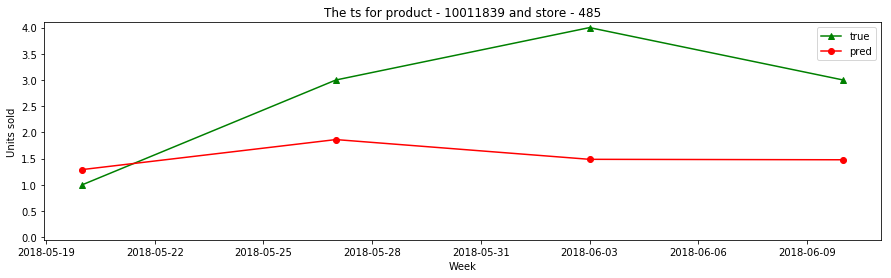

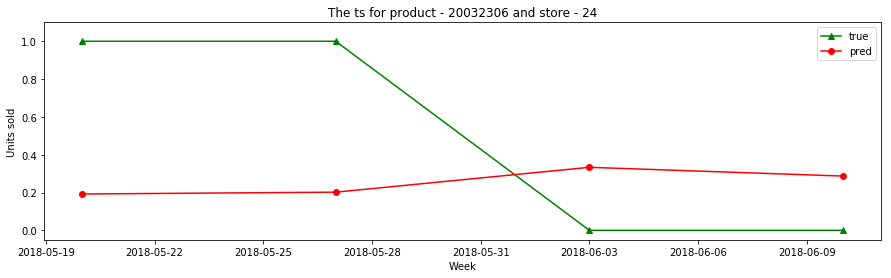

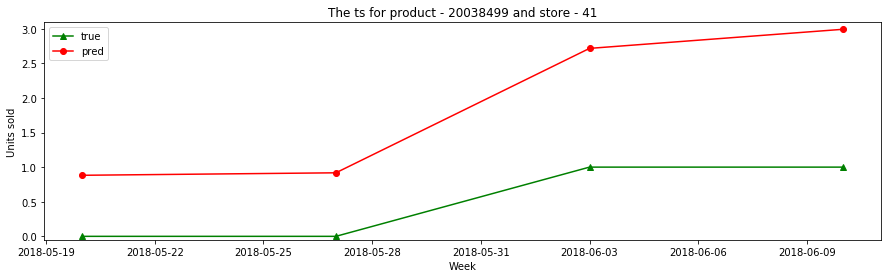

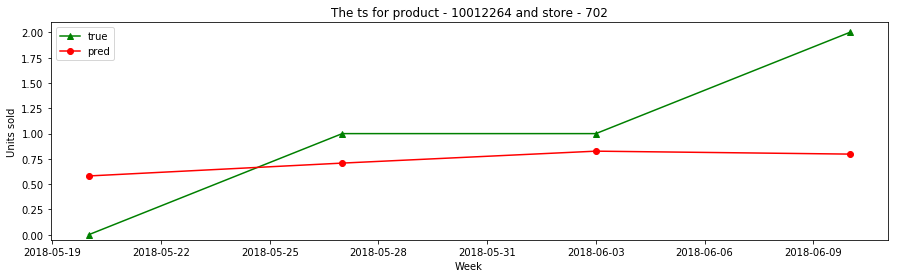

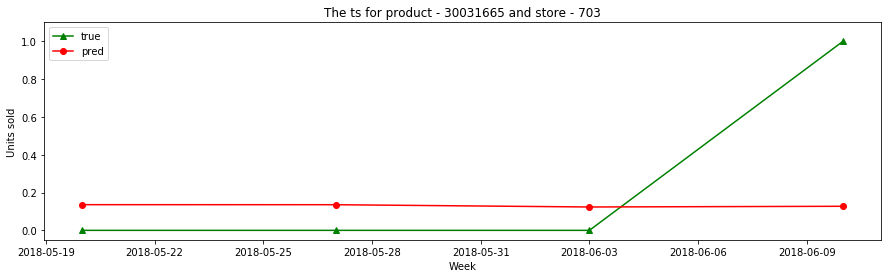

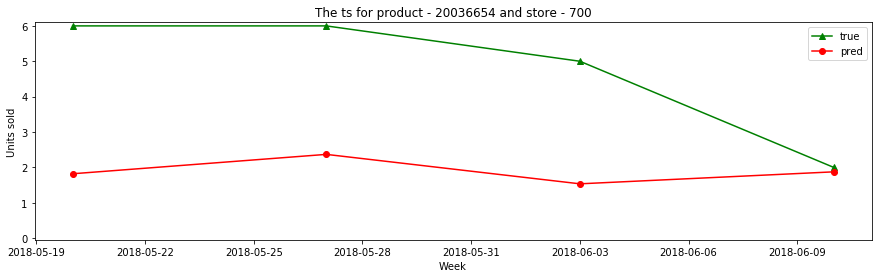

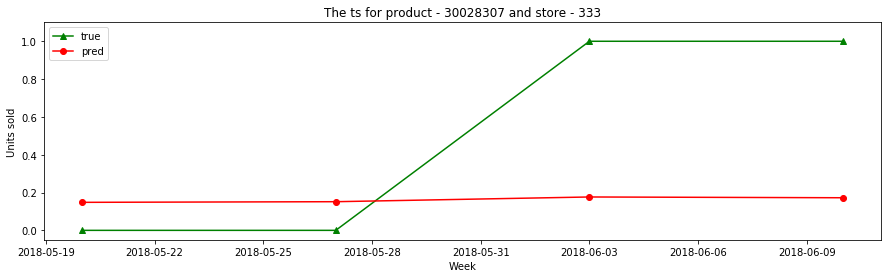

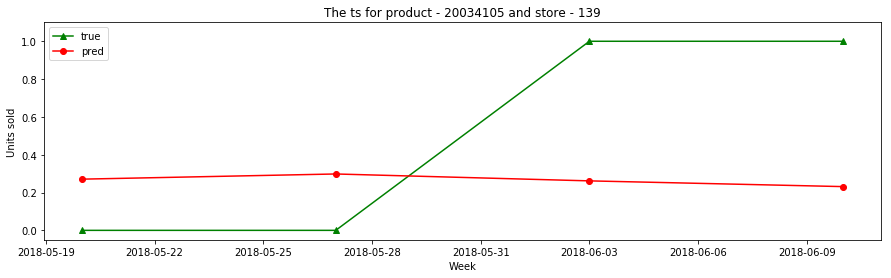

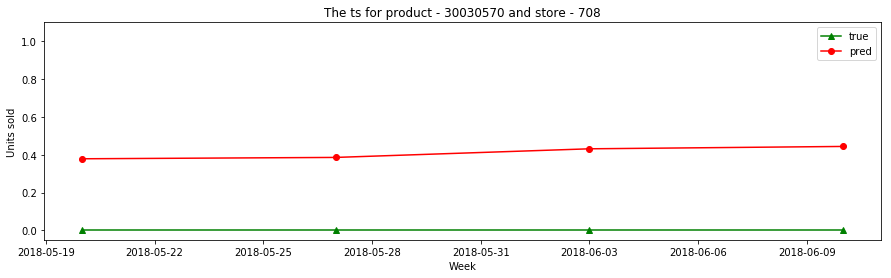

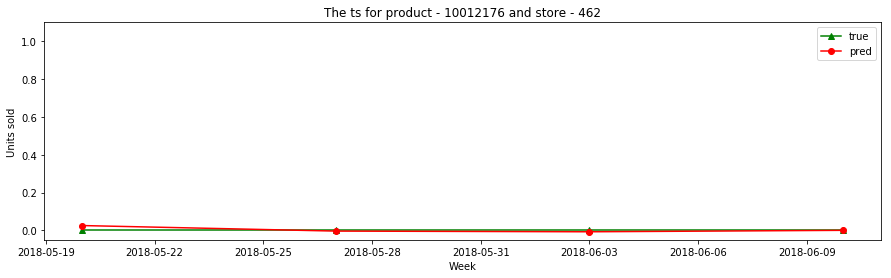

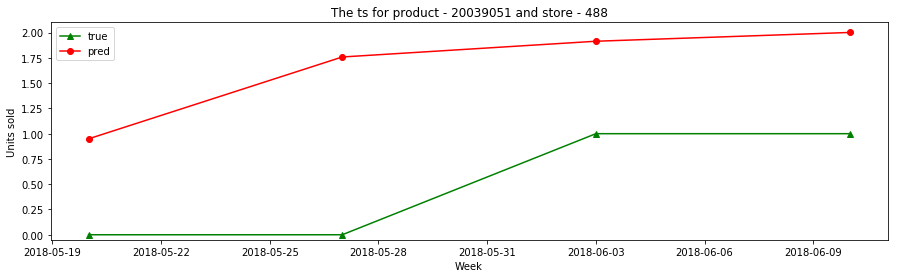

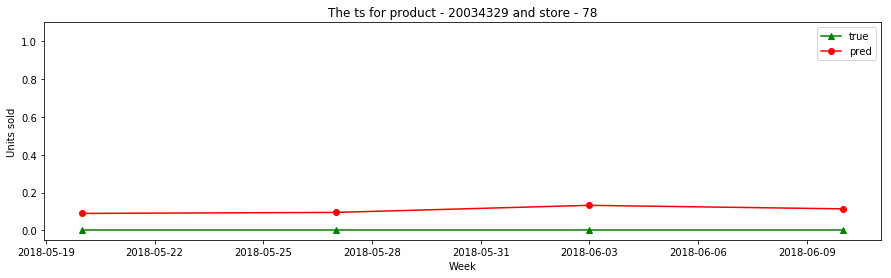

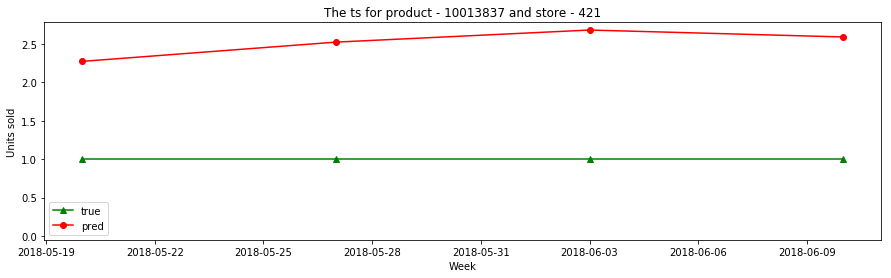

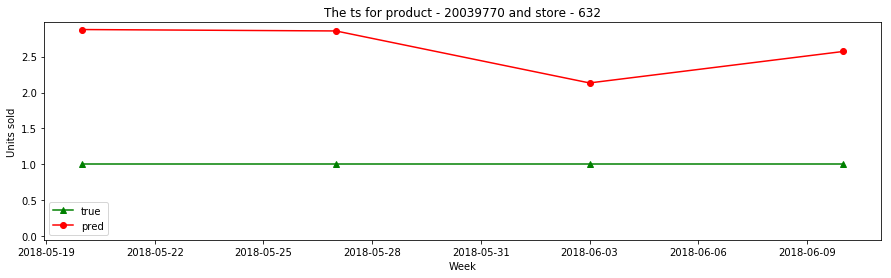

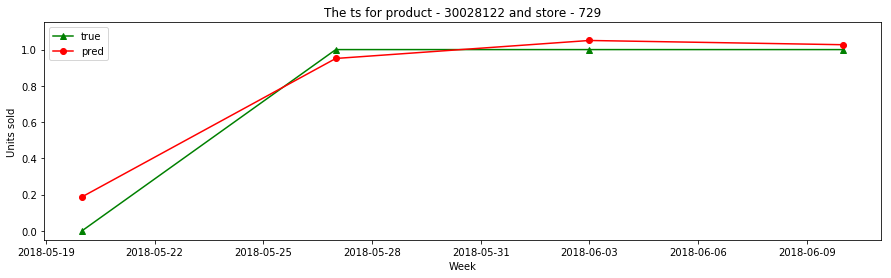

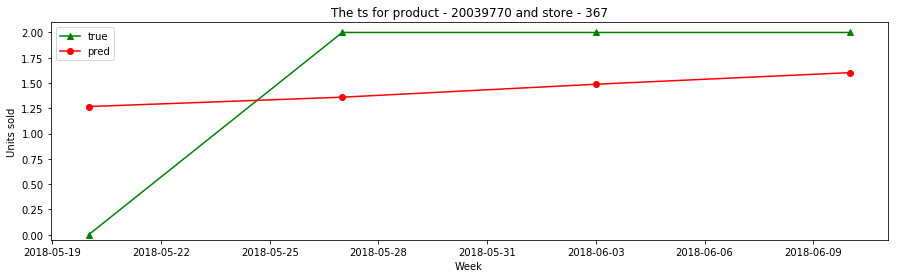

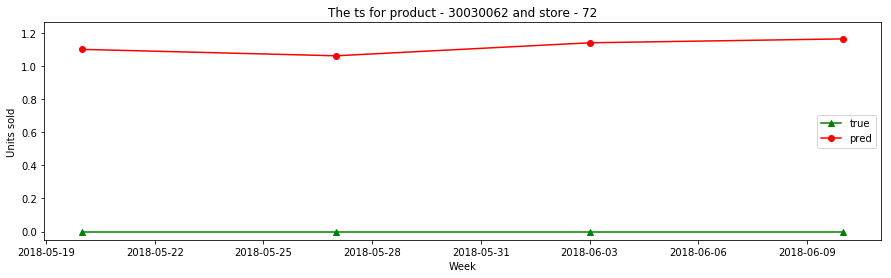

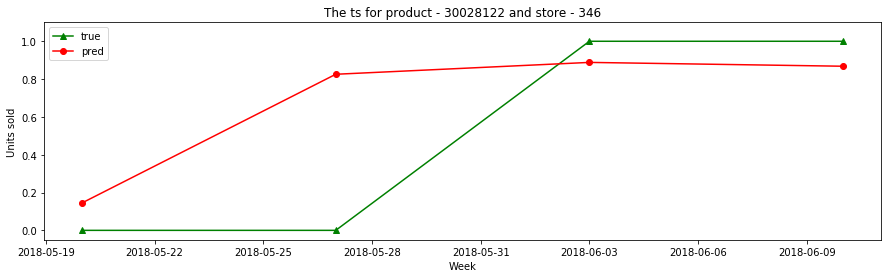

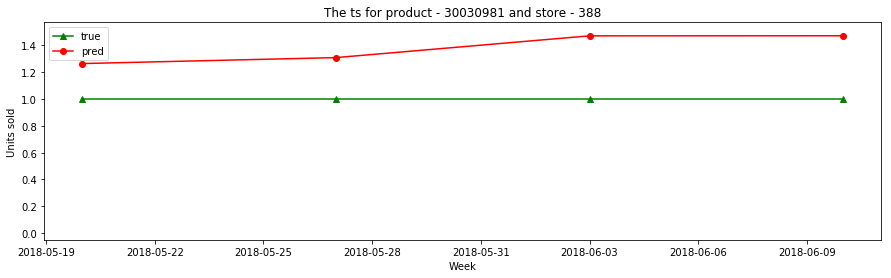

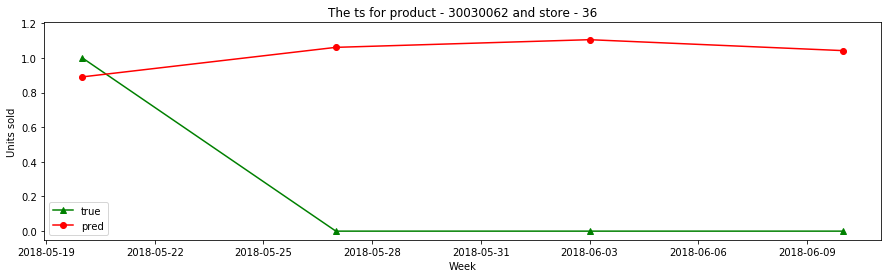

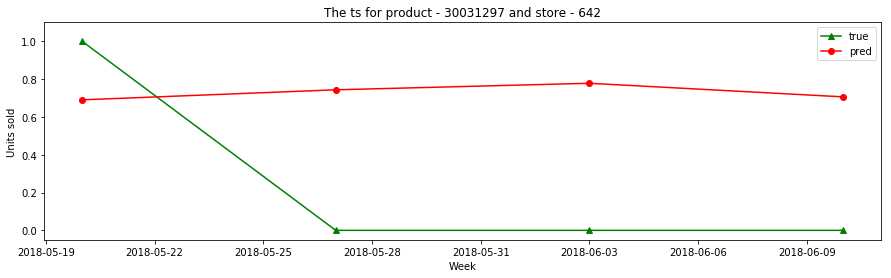

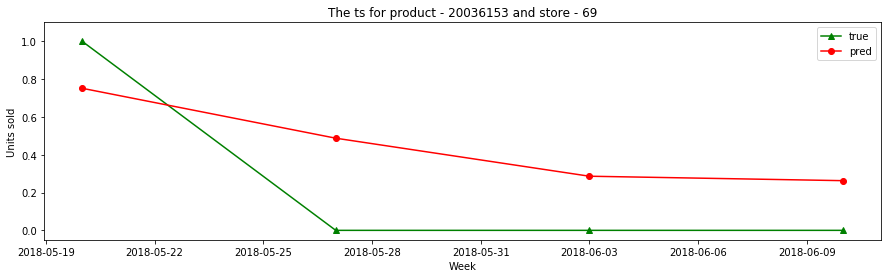

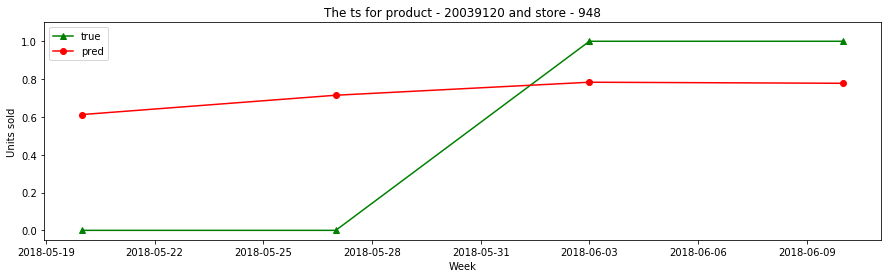

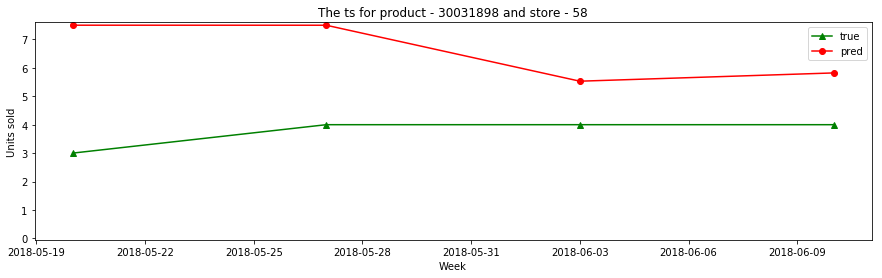

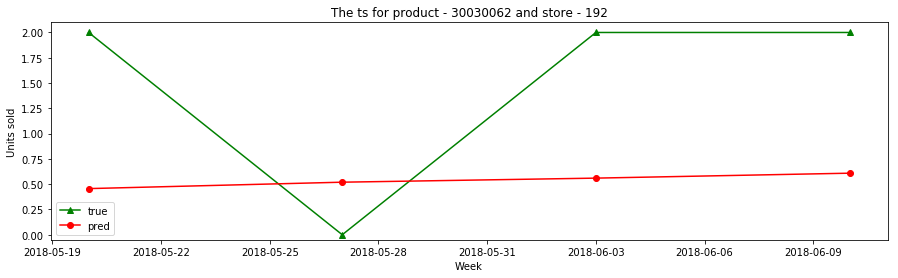

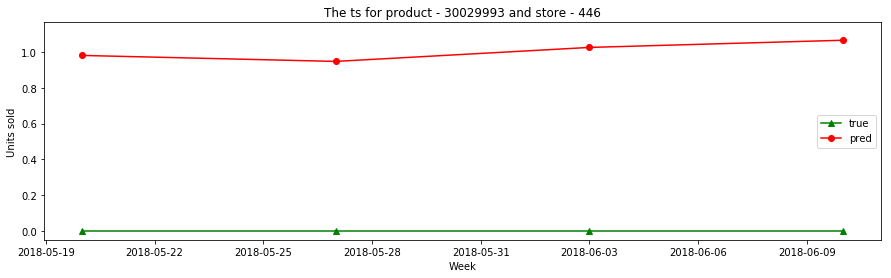

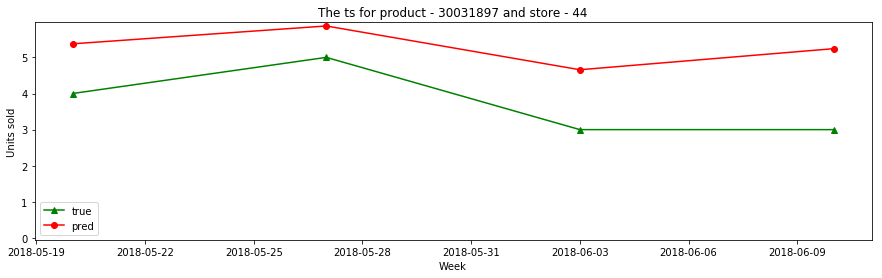

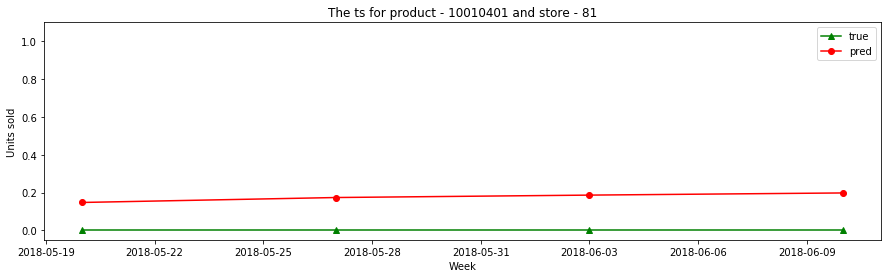

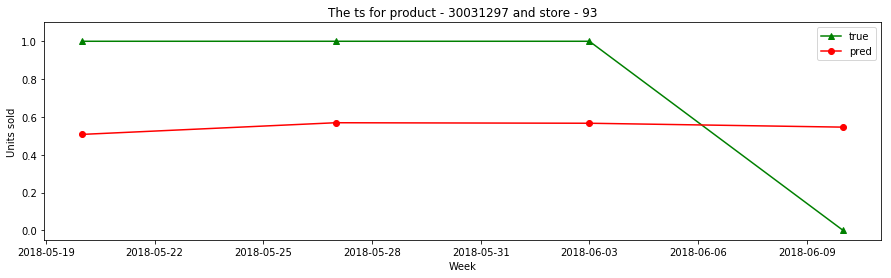

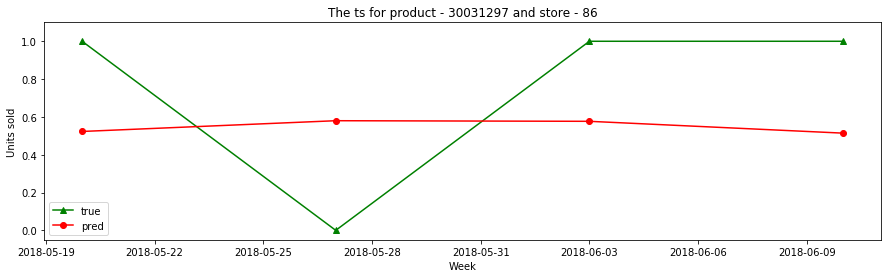

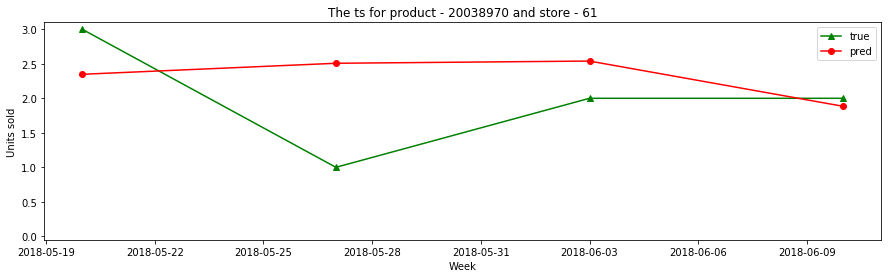

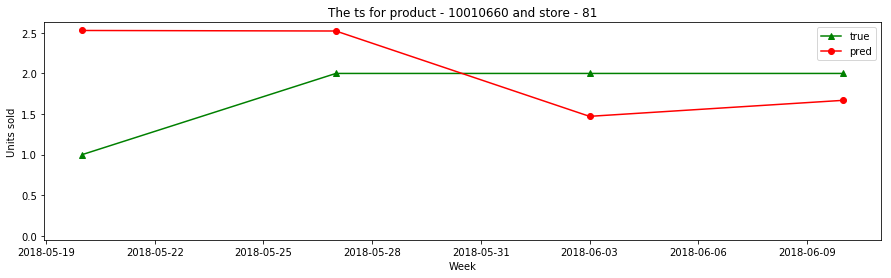

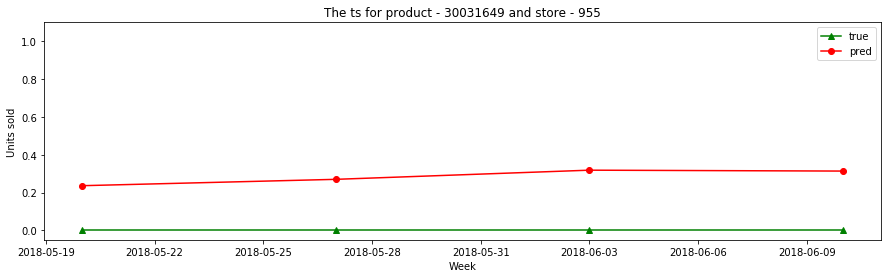

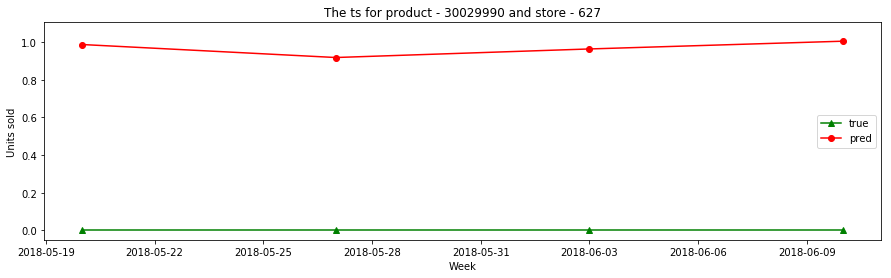

In [32]:
pairs = list(set(zip(res['STORE_ID'], res['PRODUCT_ID'])))

for i in range(len(pairs) // 1000):
    store_id, product_id = pairs[i]
    plot_ts(res, store_id, product_id)

In [33]:
dts2 = lgb.Dataset(data_train2[feat], label = data_train2.UNITS_SOLD_P1)

In [34]:
dts2 = dts2.construct()

In [35]:
bst.current_iteration()

1189

In [36]:
bst2 = lgb.train(params, dts2, num_boost_round = bst.current_iteration())

In [37]:
bst2.save_model('/main/data/MVideo_2/lgb_7_m_1_full.txt')

In [38]:
#bst2 = lgb.Booster(model_file = '/main/data/MVideo_2/lgb_7_m_1_full.txt')

In [39]:
pred2 = bst2.predict(data_test[feat])

In [40]:
res = data_test[['PRODUCT_ID', 'STORE_ID']].copy()

In [41]:
res['PRED'] = pred2

In [42]:
res2 = pd.read_parquet('/main/data/MVideo_2/dataset_test_7.parquet')

In [43]:
res2 = res2[(res2.DATE >= '2018-07-22') & (res2.DATE <= '2018-08-05')].copy()

In [44]:
res2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104370 entries, 34790 to 139159
Data columns (total 3 columns):
STORE_ID      104370 non-null category
PRODUCT_ID    104370 non-null category
DATE          104370 non-null datetime64[ns]
dtypes: category(2), datetime64[ns](1)
memory usage: 2.0 MB


In [45]:
res2 = res2.merge(res)

In [46]:
res2.PRED /= 4

In [47]:
res2.PRED.clip(lower = 0, inplace = True)

In [48]:
res2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104370 entries, 0 to 104369
Data columns (total 4 columns):
STORE_ID      104370 non-null category
PRODUCT_ID    104370 non-null category
DATE          104370 non-null datetime64[ns]
PRED          104370 non-null float64
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 2.8 MB


In [49]:
res2.to_parquet('/main/data/MVideo_2/results_7_m_1_full.parquet')

In [50]:
exp = shap.TreeExplainer(bst2)

In [51]:
shv = exp.shap_values(data_test[feat])

In [52]:
np.save('/main/data/MVideo_2/shv_7_m_1_full.npy', shv)

In [53]:
#shv = np.load('/main/data/MVideo_2/shv_7_m_1_full.npy')

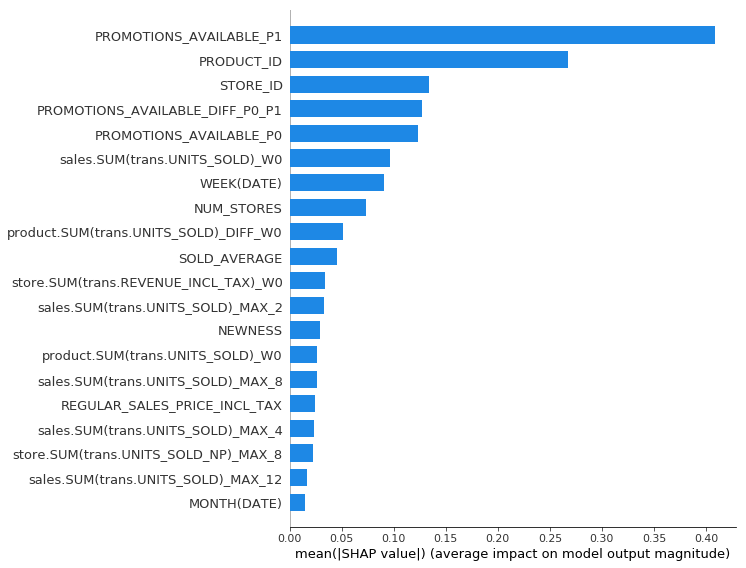

In [54]:
shap.summary_plot(shv, data_test[feat], plot_type="bar")

In [55]:
sc = np.mean(np.abs(shv), axis = 0)

In [56]:
score = pd.DataFrame(100 * sc / np.sum(sc),
                     index = bst2.feature_name(), columns = ['Score'])

In [57]:
score = score.sort_values('Score', ascending=False)

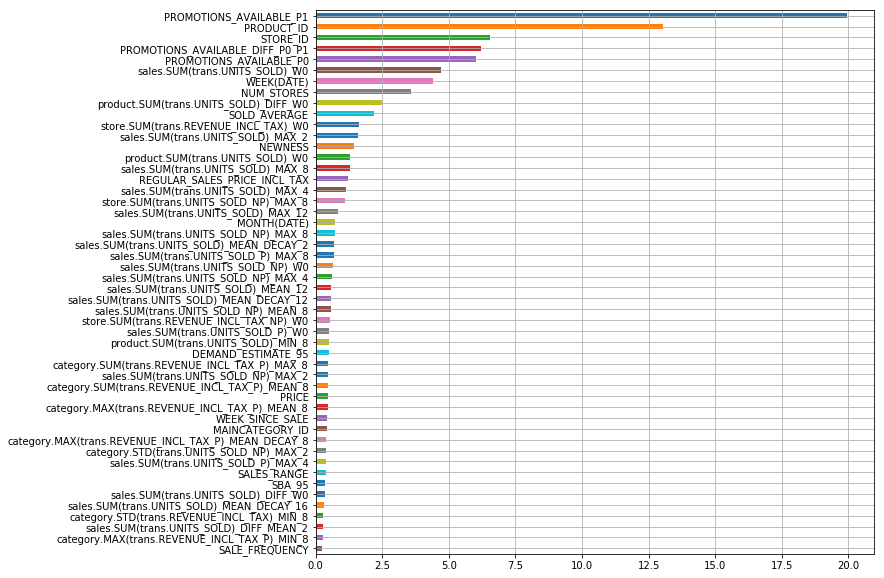

In [58]:
score.head(50).Score.plot.barh(grid=True, figsize=(10,10)).invert_yaxis()